In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : False,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'normalized','im':'t1t2','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : ['coords'],
    'features_clin' : None,
    'outp'          : 'connectivity',
    'balance_data'  : True,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_1_1_0_0_1_t1t2_normalized_e_n_e_0_0_coords_0_1_connectivity_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1t2_0_42_n_normalized_08_05_06


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(4629816, 831)
(4629816, 8)
validation
(621056, 831)
(621056, 8)
test
(624904, 831)
(624904, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 831)]             0         


 dense (Dense)               (None, 1024)              851968    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 1542024 (5.88 MB)


Trainable params: 1542024 (5.88 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


  1/463 [..............................] - ETA: 9:43 - loss: 2.7996 - STD: 0.1403 - MAE: 0.2222

  5/463 [..............................] - ETA: 6s - loss: 2.3298 - STD: 0.0628 - MAE: 0.2202  

  8/463 [..............................] - ETA: 7s - loss: 2.2334 - STD: 0.0607 - MAE: 0.2183

 12/463 [..............................] - ETA: 7s - loss: 2.1956 - STD: 0.0662 - MAE: 0.2169

 15/463 [..............................] - ETA: 7s - loss: 2.1737 - STD: 0.0639 - MAE: 0.2167

 19/463 [>.............................] - ETA: 7s - loss: 2.1501 - STD: 0.0578 - MAE: 0.2167

 23/463 [>.............................] - ETA: 7s - loss: 2.1343 - STD: 0.0525 - MAE: 0.2168

 27/463 [>.............................] - ETA: 6s - loss: 2.1229 - STD: 0.0488 - MAE: 0.2168

 31/463 [=>............................] - ETA: 6s - loss: 2.1145 - STD: 0.0463 - MAE: 0.2169

 35/463 [=>............................] - ETA: 6s - loss: 2.1071 - STD: 0.0448 - MAE: 0.2168

 39/463 [=>............................] - ETA: 6s - loss: 2.1014 - STD: 0.0440 - MAE: 0.2168

 43/463 [=>............................] - ETA: 6s - loss: 2.0968 - STD: 0.0434 - MAE: 0.2167

 47/463 [==>...........................] - ETA: 6s - loss: 2.0930 - STD: 0.0425 - MAE: 0.2167

 51/463 [==>...........................] - ETA: 6s - loss: 2.0897 - STD: 0.0416 - MAE: 0.2167

 55/463 [==>...........................] - ETA: 6s - loss: 2.0869 - STD: 0.0409 - MAE: 0.2167

 59/463 [==>...........................] - ETA: 6s - loss: 2.0844 - STD: 0.0402 - MAE: 0.2167

 63/463 [===>..........................] - ETA: 6s - loss: 2.0822 - STD: 0.0397 - MAE: 0.2167

 67/463 [===>..........................] - ETA: 6s - loss: 2.0802 - STD: 0.0392 - MAE: 0.2167

 71/463 [===>..........................] - ETA: 6s - loss: 2.0784 - STD: 0.0387 - MAE: 0.2167

 75/463 [===>..........................] - ETA: 5s - loss: 2.0766 - STD: 0.0384 - MAE: 0.2167

 79/463 [====>.........................] - ETA: 5s - loss: 2.0748 - STD: 0.0381 - MAE: 0.2167

 83/463 [====>.........................] - ETA: 5s - loss: 2.0727 - STD: 0.0378 - MAE: 0.2167

 87/463 [====>.........................] - ETA: 5s - loss: 2.0705 - STD: 0.0376 - MAE: 0.2166

 91/463 [====>.........................] - ETA: 5s - loss: 2.0678 - STD: 0.0374 - MAE: 0.2165

 95/463 [=====>........................] - ETA: 5s - loss: 2.0645 - STD: 0.0374 - MAE: 0.2165

 99/463 [=====>........................] - ETA: 5s - loss: 2.0605 - STD: 0.0375 - MAE: 0.2163

103/463 [=====>........................] - ETA: 5s - loss: 2.0556 - STD: 0.0380 - MAE: 0.2161

107/463 [=====>........................] - ETA: 5s - loss: 2.0501 - STD: 0.0387 - MAE: 0.2159

111/463 [======>.......................] - ETA: 5s - loss: 2.0439 - STD: 0.0396 - MAE: 0.2156

115/463 [======>.......................] - ETA: 5s - loss: 2.0373 - STD: 0.0405 - MAE: 0.2154

119/463 [======>.......................] - ETA: 5s - loss: 2.0300 - STD: 0.0416 - MAE: 0.2150

123/463 [======>.......................] - ETA: 5s - loss: 2.0225 - STD: 0.0428 - MAE: 0.2147

127/463 [=======>......................] - ETA: 5s - loss: 2.0148 - STD: 0.0440 - MAE: 0.2143

131/463 [=======>......................] - ETA: 5s - loss: 2.0072 - STD: 0.0453 - MAE: 0.2139

135/463 [=======>......................] - ETA: 5s - loss: 1.9995 - STD: 0.0465 - MAE: 0.2136

139/463 [========>.....................] - ETA: 4s - loss: 1.9919 - STD: 0.0477 - MAE: 0.2132

143/463 [========>.....................] - ETA: 4s - loss: 1.9843 - STD: 0.0489 - MAE: 0.2128

147/463 [========>.....................] - ETA: 4s - loss: 1.9769 - STD: 0.0502 - MAE: 0.2124

151/463 [========>.....................] - ETA: 4s - loss: 1.9695 - STD: 0.0514 - MAE: 0.2120

155/463 [=========>....................] - ETA: 4s - loss: 1.9622 - STD: 0.0526 - MAE: 0.2117

159/463 [=========>....................] - ETA: 4s - loss: 1.9549 - STD: 0.0537 - MAE: 0.2113

163/463 [=========>....................] - ETA: 4s - loss: 1.9476 - STD: 0.0549 - MAE: 0.2109

167/463 [=========>....................] - ETA: 4s - loss: 1.9398 - STD: 0.0560 - MAE: 0.2105

171/463 [==========>...................] - ETA: 4s - loss: 1.9316 - STD: 0.0572 - MAE: 0.2100

175/463 [==========>...................] - ETA: 4s - loss: 1.9231 - STD: 0.0583 - MAE: 0.2095

179/463 [==========>...................] - ETA: 4s - loss: 1.9142 - STD: 0.0596 - MAE: 0.2090

183/463 [==========>...................] - ETA: 4s - loss: 1.9057 - STD: 0.0610 - MAE: 0.2085

187/463 [===========>..................] - ETA: 4s - loss: 1.8969 - STD: 0.0624 - MAE: 0.2079

191/463 [===========>..................] - ETA: 4s - loss: 1.8879 - STD: 0.0639 - MAE: 0.2073

195/463 [===========>..................] - ETA: 4s - loss: 1.8789 - STD: 0.0653 - MAE: 0.2067

199/463 [===========>..................] - ETA: 4s - loss: 1.8702 - STD: 0.0667 - MAE: 0.2062

203/463 [============>.................] - ETA: 3s - loss: 1.8616 - STD: 0.0681 - MAE: 0.2056

207/463 [============>.................] - ETA: 3s - loss: 1.8531 - STD: 0.0695 - MAE: 0.2050

211/463 [============>.................] - ETA: 3s - loss: 1.8446 - STD: 0.0708 - MAE: 0.2045

215/463 [============>.................] - ETA: 3s - loss: 1.8364 - STD: 0.0722 - MAE: 0.2039

219/463 [=============>................] - ETA: 3s - loss: 1.8284 - STD: 0.0735 - MAE: 0.2033

223/463 [=============>................] - ETA: 3s - loss: 1.8203 - STD: 0.0748 - MAE: 0.2028

227/463 [=============>................] - ETA: 3s - loss: 1.8124 - STD: 0.0761 - MAE: 0.2022

231/463 [=============>................] - ETA: 3s - loss: 1.8046 - STD: 0.0774 - MAE: 0.2017

235/463 [==============>...............] - ETA: 3s - loss: 1.7969 - STD: 0.0786 - MAE: 0.2011

239/463 [==============>...............] - ETA: 3s - loss: 1.7896 - STD: 0.0798 - MAE: 0.2006

243/463 [==============>...............] - ETA: 3s - loss: 1.7826 - STD: 0.0810 - MAE: 0.2001

247/463 [===============>..............] - ETA: 3s - loss: 1.7756 - STD: 0.0822 - MAE: 0.1996

251/463 [===============>..............] - ETA: 3s - loss: 1.7688 - STD: 0.0834 - MAE: 0.1991

255/463 [===============>..............] - ETA: 3s - loss: 1.7620 - STD: 0.0846 - MAE: 0.1985

259/463 [===============>..............] - ETA: 3s - loss: 1.7553 - STD: 0.0857 - MAE: 0.1980

263/463 [================>.............] - ETA: 3s - loss: 1.7488 - STD: 0.0868 - MAE: 0.1976

267/463 [================>.............] - ETA: 3s - loss: 1.7425 - STD: 0.0879 - MAE: 0.1971

271/463 [================>.............] - ETA: 3s - loss: 1.7363 - STD: 0.0889 - MAE: 0.1966

275/463 [================>.............] - ETA: 3s - loss: 1.7301 - STD: 0.0900 - MAE: 0.1961

279/463 [=================>............] - ETA: 3s - loss: 1.7241 - STD: 0.0910 - MAE: 0.1957

283/463 [=================>............] - ETA: 3s - loss: 1.7182 - STD: 0.0920 - MAE: 0.1952

287/463 [=================>............] - ETA: 3s - loss: 1.7123 - STD: 0.0930 - MAE: 0.1948

291/463 [=================>............] - ETA: 3s - loss: 1.7066 - STD: 0.0939 - MAE: 0.1944

295/463 [==================>...........] - ETA: 2s - loss: 1.7014 - STD: 0.0948 - MAE: 0.1939

299/463 [==================>...........] - ETA: 2s - loss: 1.6961 - STD: 0.0958 - MAE: 0.1935

303/463 [==================>...........] - ETA: 2s - loss: 1.6908 - STD: 0.0967 - MAE: 0.1931

307/463 [==================>...........] - ETA: 2s - loss: 1.6856 - STD: 0.0976 - MAE: 0.1927

311/463 [===================>..........] - ETA: 2s - loss: 1.6805 - STD: 0.0985 - MAE: 0.1923

315/463 [===================>..........] - ETA: 2s - loss: 1.6754 - STD: 0.0993 - MAE: 0.1919

319/463 [===================>..........] - ETA: 2s - loss: 1.6703 - STD: 0.1002 - MAE: 0.1915

323/463 [===================>..........] - ETA: 2s - loss: 1.6655 - STD: 0.1010 - MAE: 0.1911

327/463 [====================>.........] - ETA: 2s - loss: 1.6606 - STD: 0.1018 - MAE: 0.1908

331/463 [====================>.........] - ETA: 2s - loss: 1.6559 - STD: 0.1026 - MAE: 0.1904

335/463 [====================>.........] - ETA: 2s - loss: 1.6512 - STD: 0.1034 - MAE: 0.1900

339/463 [====================>.........] - ETA: 2s - loss: 1.6467 - STD: 0.1042 - MAE: 0.1896

343/463 [=====================>........] - ETA: 2s - loss: 1.6422 - STD: 0.1049 - MAE: 0.1893

347/463 [=====================>........] - ETA: 1s - loss: 1.6378 - STD: 0.1057 - MAE: 0.1889

351/463 [=====================>........] - ETA: 1s - loss: 1.6335 - STD: 0.1065 - MAE: 0.1886

355/463 [======================>.......] - ETA: 1s - loss: 1.6292 - STD: 0.1072 - MAE: 0.1882

359/463 [======================>.......] - ETA: 1s - loss: 1.6251 - STD: 0.1079 - MAE: 0.1879

363/463 [======================>.......] - ETA: 1s - loss: 1.6210 - STD: 0.1086 - MAE: 0.1876

367/463 [======================>.......] - ETA: 1s - loss: 1.6168 - STD: 0.1093 - MAE: 0.1873

371/463 [=======================>......] - ETA: 1s - loss: 1.6128 - STD: 0.1100 - MAE: 0.1869

375/463 [=======================>......] - ETA: 1s - loss: 1.6089 - STD: 0.1107 - MAE: 0.1866

379/463 [=======================>......] - ETA: 1s - loss: 1.6050 - STD: 0.1113 - MAE: 0.1863

383/463 [=======================>......] - ETA: 1s - loss: 1.6011 - STD: 0.1120 - MAE: 0.1860

387/463 [========================>.....] - ETA: 1s - loss: 1.5973 - STD: 0.1126 - MAE: 0.1857

391/463 [========================>.....] - ETA: 1s - loss: 1.5934 - STD: 0.1133 - MAE: 0.1854

395/463 [========================>.....] - ETA: 1s - loss: 1.5897 - STD: 0.1139 - MAE: 0.1851

399/463 [========================>.....] - ETA: 1s - loss: 1.5860 - STD: 0.1145 - MAE: 0.1848

403/463 [=========================>....] - ETA: 1s - loss: 1.5824 - STD: 0.1151 - MAE: 0.1845

407/463 [=========================>....] - ETA: 0s - loss: 1.5790 - STD: 0.1157 - MAE: 0.1842

411/463 [=========================>....] - ETA: 0s - loss: 1.5755 - STD: 0.1163 - MAE: 0.1839

415/463 [=========================>....] - ETA: 0s - loss: 1.5722 - STD: 0.1169 - MAE: 0.1836

419/463 [==========================>...] - ETA: 0s - loss: 1.5689 - STD: 0.1175 - MAE: 0.1834

423/463 [==========================>...] - ETA: 0s - loss: 1.5656 - STD: 0.1180 - MAE: 0.1831

427/463 [==========================>...] - ETA: 0s - loss: 1.5623 - STD: 0.1186 - MAE: 0.1828

431/463 [==========================>...] - ETA: 0s - loss: 1.5590 - STD: 0.1191 - MAE: 0.1826

435/463 [===========================>..] - ETA: 0s - loss: 1.5557 - STD: 0.1196 - MAE: 0.1823

439/463 [===========================>..] - ETA: 0s - loss: 1.5525 - STD: 0.1202 - MAE: 0.1820

443/463 [===========================>..] - ETA: 0s - loss: 1.5493 - STD: 0.1207 - MAE: 0.1818

446/463 [===========================>..] - ETA: 0s - loss: 1.5470 - STD: 0.1211 - MAE: 0.1816

450/463 [============================>.] - ETA: 0s - loss: 1.5440 - STD: 0.1216 - MAE: 0.1813

454/463 [============================>.] - ETA: 0s - loss: 1.5410 - STD: 0.1221 - MAE: 0.1811

458/463 [============================>.] - ETA: 0s - loss: 1.5379 - STD: 0.1226 - MAE: 0.1808

462/463 [============================>.] - ETA: 0s - loss: 1.5350 - STD: 0.1231 - MAE: 0.1806

463/463 [==============================] - 10s 20ms/step - loss: 1.5343 - STD: 0.1232 - MAE: 0.1805 - val_loss: 1.2480 - val_STD: 0.1722 - val_MAE: 0.1569


Epoch 2/10000


  1/463 [..............................] - ETA: 20s - loss: 1.1783 - STD: 0.1791 - MAE: 0.1517

  5/463 [..............................] - ETA: 7s - loss: 1.1876 - STD: 0.1797 - MAE: 0.1522 

  9/463 [..............................] - ETA: 7s - loss: 1.1919 - STD: 0.1797 - MAE: 0.1524

 13/463 [..............................] - ETA: 6s - loss: 1.1901 - STD: 0.1801 - MAE: 0.1522

 17/463 [>.............................] - ETA: 6s - loss: 1.1884 - STD: 0.1804 - MAE: 0.1520

 21/463 [>.............................] - ETA: 6s - loss: 1.1883 - STD: 0.1805 - MAE: 0.1519

 25/463 [>.............................] - ETA: 6s - loss: 1.1863 - STD: 0.1806 - MAE: 0.1518

 29/463 [>.............................] - ETA: 6s - loss: 1.1836 - STD: 0.1809 - MAE: 0.1516

 33/463 [=>............................] - ETA: 6s - loss: 1.1826 - STD: 0.1809 - MAE: 0.1515

 37/463 [=>............................] - ETA: 6s - loss: 1.1831 - STD: 0.1811 - MAE: 0.1515

 41/463 [=>............................] - ETA: 6s - loss: 1.1832 - STD: 0.1814 - MAE: 0.1514

 45/463 [=>............................] - ETA: 6s - loss: 1.1839 - STD: 0.1816 - MAE: 0.1514

 49/463 [==>...........................] - ETA: 6s - loss: 1.1832 - STD: 0.1816 - MAE: 0.1513

 53/463 [==>...........................] - ETA: 6s - loss: 1.1827 - STD: 0.1816 - MAE: 0.1513

 57/463 [==>...........................] - ETA: 6s - loss: 1.1815 - STD: 0.1818 - MAE: 0.1512

 61/463 [==>...........................] - ETA: 6s - loss: 1.1809 - STD: 0.1819 - MAE: 0.1511

 65/463 [===>..........................] - ETA: 6s - loss: 1.1795 - STD: 0.1819 - MAE: 0.1510

 69/463 [===>..........................] - ETA: 6s - loss: 1.1781 - STD: 0.1821 - MAE: 0.1509

 73/463 [===>..........................] - ETA: 5s - loss: 1.1768 - STD: 0.1822 - MAE: 0.1508

 77/463 [===>..........................] - ETA: 5s - loss: 1.1761 - STD: 0.1822 - MAE: 0.1508

 81/463 [====>.........................] - ETA: 5s - loss: 1.1752 - STD: 0.1824 - MAE: 0.1507

 85/463 [====>.........................] - ETA: 5s - loss: 1.1743 - STD: 0.1825 - MAE: 0.1506

 89/463 [====>.........................] - ETA: 5s - loss: 1.1734 - STD: 0.1826 - MAE: 0.1505

 93/463 [=====>........................] - ETA: 5s - loss: 1.1726 - STD: 0.1827 - MAE: 0.1504

 96/463 [=====>........................] - ETA: 5s - loss: 1.1724 - STD: 0.1828 - MAE: 0.1504

100/463 [=====>........................] - ETA: 5s - loss: 1.1716 - STD: 0.1829 - MAE: 0.1503

104/463 [=====>........................] - ETA: 5s - loss: 1.1712 - STD: 0.1830 - MAE: 0.1502

108/463 [=====>........................] - ETA: 5s - loss: 1.1703 - STD: 0.1832 - MAE: 0.1501

111/463 [======>.......................] - ETA: 5s - loss: 1.1695 - STD: 0.1833 - MAE: 0.1501

115/463 [======>.......................] - ETA: 5s - loss: 1.1686 - STD: 0.1834 - MAE: 0.1500

119/463 [======>.......................] - ETA: 5s - loss: 1.1677 - STD: 0.1834 - MAE: 0.1499

123/463 [======>.......................] - ETA: 5s - loss: 1.1675 - STD: 0.1835 - MAE: 0.1499

126/463 [=======>......................] - ETA: 5s - loss: 1.1667 - STD: 0.1836 - MAE: 0.1498

130/463 [=======>......................] - ETA: 5s - loss: 1.1660 - STD: 0.1837 - MAE: 0.1497

134/463 [=======>......................] - ETA: 5s - loss: 1.1654 - STD: 0.1838 - MAE: 0.1496

138/463 [=======>......................] - ETA: 5s - loss: 1.1646 - STD: 0.1839 - MAE: 0.1496

142/463 [========>.....................] - ETA: 4s - loss: 1.1635 - STD: 0.1840 - MAE: 0.1495

146/463 [========>.....................] - ETA: 4s - loss: 1.1631 - STD: 0.1842 - MAE: 0.1494

150/463 [========>.....................] - ETA: 4s - loss: 1.1622 - STD: 0.1843 - MAE: 0.1493

154/463 [========>.....................] - ETA: 4s - loss: 1.1613 - STD: 0.1844 - MAE: 0.1492

158/463 [=========>....................] - ETA: 4s - loss: 1.1610 - STD: 0.1845 - MAE: 0.1492

162/463 [=========>....................] - ETA: 4s - loss: 1.1607 - STD: 0.1845 - MAE: 0.1491

166/463 [=========>....................] - ETA: 4s - loss: 1.1602 - STD: 0.1846 - MAE: 0.1491

170/463 [==========>...................] - ETA: 4s - loss: 1.1599 - STD: 0.1848 - MAE: 0.1490

174/463 [==========>...................] - ETA: 4s - loss: 1.1595 - STD: 0.1849 - MAE: 0.1489

178/463 [==========>...................] - ETA: 4s - loss: 1.1593 - STD: 0.1850 - MAE: 0.1489

182/463 [==========>...................] - ETA: 4s - loss: 1.1588 - STD: 0.1850 - MAE: 0.1488

186/463 [===========>..................] - ETA: 4s - loss: 1.1580 - STD: 0.1851 - MAE: 0.1488

190/463 [===========>..................] - ETA: 4s - loss: 1.1572 - STD: 0.1852 - MAE: 0.1487

194/463 [===========>..................] - ETA: 4s - loss: 1.1564 - STD: 0.1852 - MAE: 0.1486

198/463 [===========>..................] - ETA: 4s - loss: 1.1556 - STD: 0.1853 - MAE: 0.1486

202/463 [============>.................] - ETA: 4s - loss: 1.1549 - STD: 0.1854 - MAE: 0.1485

206/463 [============>.................] - ETA: 3s - loss: 1.1542 - STD: 0.1855 - MAE: 0.1484

210/463 [============>.................] - ETA: 3s - loss: 1.1536 - STD: 0.1856 - MAE: 0.1484

214/463 [============>.................] - ETA: 3s - loss: 1.1532 - STD: 0.1857 - MAE: 0.1483

218/463 [=============>................] - ETA: 3s - loss: 1.1525 - STD: 0.1858 - MAE: 0.1482

222/463 [=============>................] - ETA: 3s - loss: 1.1518 - STD: 0.1859 - MAE: 0.1481

226/463 [=============>................] - ETA: 3s - loss: 1.1514 - STD: 0.1860 - MAE: 0.1481

230/463 [=============>................] - ETA: 3s - loss: 1.1506 - STD: 0.1861 - MAE: 0.1480

234/463 [==============>...............] - ETA: 3s - loss: 1.1498 - STD: 0.1862 - MAE: 0.1479

238/463 [==============>...............] - ETA: 3s - loss: 1.1491 - STD: 0.1863 - MAE: 0.1479

242/463 [==============>...............] - ETA: 3s - loss: 1.1481 - STD: 0.1863 - MAE: 0.1478

246/463 [==============>...............] - ETA: 3s - loss: 1.1473 - STD: 0.1864 - MAE: 0.1477

250/463 [===============>..............] - ETA: 3s - loss: 1.1475 - STD: 0.1866 - MAE: 0.1477

254/463 [===============>..............] - ETA: 3s - loss: 1.1470 - STD: 0.1867 - MAE: 0.1476

258/463 [===============>..............] - ETA: 3s - loss: 1.1465 - STD: 0.1867 - MAE: 0.1476

262/463 [===============>..............] - ETA: 3s - loss: 1.1458 - STD: 0.1868 - MAE: 0.1475

266/463 [================>.............] - ETA: 3s - loss: 1.1453 - STD: 0.1869 - MAE: 0.1474

270/463 [================>.............] - ETA: 2s - loss: 1.1448 - STD: 0.1870 - MAE: 0.1474

274/463 [================>.............] - ETA: 2s - loss: 1.1441 - STD: 0.1871 - MAE: 0.1473

278/463 [=================>............] - ETA: 2s - loss: 1.1433 - STD: 0.1872 - MAE: 0.1472

282/463 [=================>............] - ETA: 2s - loss: 1.1425 - STD: 0.1873 - MAE: 0.1471

286/463 [=================>............] - ETA: 2s - loss: 1.1418 - STD: 0.1874 - MAE: 0.1471

290/463 [=================>............] - ETA: 2s - loss: 1.1411 - STD: 0.1874 - MAE: 0.1470

294/463 [==================>...........] - ETA: 2s - loss: 1.1403 - STD: 0.1875 - MAE: 0.1469

298/463 [==================>...........] - ETA: 2s - loss: 1.1394 - STD: 0.1876 - MAE: 0.1469

302/463 [==================>...........] - ETA: 2s - loss: 1.1385 - STD: 0.1877 - MAE: 0.1468

306/463 [==================>...........] - ETA: 2s - loss: 1.1378 - STD: 0.1878 - MAE: 0.1467

310/463 [===================>..........] - ETA: 2s - loss: 1.1370 - STD: 0.1879 - MAE: 0.1466

314/463 [===================>..........] - ETA: 2s - loss: 1.1361 - STD: 0.1880 - MAE: 0.1465

318/463 [===================>..........] - ETA: 2s - loss: 1.1356 - STD: 0.1881 - MAE: 0.1465

322/463 [===================>..........] - ETA: 2s - loss: 1.1351 - STD: 0.1882 - MAE: 0.1464

326/463 [====================>.........] - ETA: 2s - loss: 1.1348 - STD: 0.1883 - MAE: 0.1464

330/463 [====================>.........] - ETA: 2s - loss: 1.1342 - STD: 0.1884 - MAE: 0.1463

334/463 [====================>.........] - ETA: 1s - loss: 1.1335 - STD: 0.1885 - MAE: 0.1462

338/463 [====================>.........] - ETA: 1s - loss: 1.1328 - STD: 0.1886 - MAE: 0.1461

342/463 [=====================>........] - ETA: 1s - loss: 1.1321 - STD: 0.1886 - MAE: 0.1461

346/463 [=====================>........] - ETA: 1s - loss: 1.1314 - STD: 0.1887 - MAE: 0.1460

350/463 [=====================>........] - ETA: 1s - loss: 1.1306 - STD: 0.1888 - MAE: 0.1459

354/463 [=====================>........] - ETA: 1s - loss: 1.1298 - STD: 0.1889 - MAE: 0.1458

358/463 [======================>.......] - ETA: 1s - loss: 1.1292 - STD: 0.1890 - MAE: 0.1458

362/463 [======================>.......] - ETA: 1s - loss: 1.1286 - STD: 0.1891 - MAE: 0.1457

366/463 [======================>.......] - ETA: 1s - loss: 1.1281 - STD: 0.1892 - MAE: 0.1457

370/463 [======================>.......] - ETA: 1s - loss: 1.1276 - STD: 0.1893 - MAE: 0.1456

374/463 [=======================>......] - ETA: 1s - loss: 1.1270 - STD: 0.1894 - MAE: 0.1455

378/463 [=======================>......] - ETA: 1s - loss: 1.1266 - STD: 0.1894 - MAE: 0.1455

382/463 [=======================>......] - ETA: 1s - loss: 1.1258 - STD: 0.1895 - MAE: 0.1454

386/463 [========================>.....] - ETA: 1s - loss: 1.1252 - STD: 0.1896 - MAE: 0.1453

390/463 [========================>.....] - ETA: 1s - loss: 1.1246 - STD: 0.1897 - MAE: 0.1453

394/463 [========================>.....] - ETA: 1s - loss: 1.1240 - STD: 0.1898 - MAE: 0.1452

398/463 [========================>.....] - ETA: 1s - loss: 1.1233 - STD: 0.1899 - MAE: 0.1451

402/463 [=========================>....] - ETA: 0s - loss: 1.1226 - STD: 0.1900 - MAE: 0.1451

406/463 [=========================>....] - ETA: 0s - loss: 1.1223 - STD: 0.1901 - MAE: 0.1450

410/463 [=========================>....] - ETA: 0s - loss: 1.1218 - STD: 0.1901 - MAE: 0.1449

414/463 [=========================>....] - ETA: 0s - loss: 1.1214 - STD: 0.1902 - MAE: 0.1449

418/463 [==========================>...] - ETA: 0s - loss: 1.1209 - STD: 0.1903 - MAE: 0.1448

422/463 [==========================>...] - ETA: 0s - loss: 1.1204 - STD: 0.1904 - MAE: 0.1448

426/463 [==========================>...] - ETA: 0s - loss: 1.1197 - STD: 0.1905 - MAE: 0.1447

430/463 [==========================>...] - ETA: 0s - loss: 1.1191 - STD: 0.1906 - MAE: 0.1446

434/463 [===========================>..] - ETA: 0s - loss: 1.1185 - STD: 0.1906 - MAE: 0.1446

438/463 [===========================>..] - ETA: 0s - loss: 1.1178 - STD: 0.1907 - MAE: 0.1445

442/463 [===========================>..] - ETA: 0s - loss: 1.1172 - STD: 0.1908 - MAE: 0.1444

446/463 [===========================>..] - ETA: 0s - loss: 1.1165 - STD: 0.1909 - MAE: 0.1444

450/463 [============================>.] - ETA: 0s - loss: 1.1158 - STD: 0.1910 - MAE: 0.1443

454/463 [============================>.] - ETA: 0s - loss: 1.1152 - STD: 0.1911 - MAE: 0.1442

458/463 [============================>.] - ETA: 0s - loss: 1.1144 - STD: 0.1911 - MAE: 0.1442

462/463 [============================>.] - ETA: 0s - loss: 1.1138 - STD: 0.1912 - MAE: 0.1441

463/463 [==============================] - 8s 17ms/step - loss: 1.1136 - STD: 0.1912 - MAE: 0.1441 - val_loss: 1.1140 - val_STD: 0.1953 - val_MAE: 0.1425


Epoch 3/10000


  1/463 [..............................] - ETA: 17s - loss: 1.0374 - STD: 0.2010 - MAE: 0.1363

  5/463 [..............................] - ETA: 7s - loss: 1.0359 - STD: 0.2011 - MAE: 0.1359 

  9/463 [..............................] - ETA: 7s - loss: 1.0398 - STD: 0.2016 - MAE: 0.1360

 13/463 [..............................] - ETA: 6s - loss: 1.0447 - STD: 0.2019 - MAE: 0.1361

 17/463 [>.............................] - ETA: 6s - loss: 1.0530 - STD: 0.2021 - MAE: 0.1365

 21/463 [>.............................] - ETA: 6s - loss: 1.0503 - STD: 0.2022 - MAE: 0.1363

 25/463 [>.............................] - ETA: 6s - loss: 1.0474 - STD: 0.2023 - MAE: 0.1361

 29/463 [>.............................] - ETA: 6s - loss: 1.0456 - STD: 0.2024 - MAE: 0.1360

 33/463 [=>............................] - ETA: 6s - loss: 1.0449 - STD: 0.2022 - MAE: 0.1360

 37/463 [=>............................] - ETA: 6s - loss: 1.0438 - STD: 0.2022 - MAE: 0.1360

 41/463 [=>............................] - ETA: 6s - loss: 1.0444 - STD: 0.2022 - MAE: 0.1360

 45/463 [=>............................] - ETA: 6s - loss: 1.0443 - STD: 0.2023 - MAE: 0.1360

 49/463 [==>...........................] - ETA: 6s - loss: 1.0439 - STD: 0.2023 - MAE: 0.1359

 53/463 [==>...........................] - ETA: 6s - loss: 1.0435 - STD: 0.2023 - MAE: 0.1359

 57/463 [==>...........................] - ETA: 6s - loss: 1.0421 - STD: 0.2023 - MAE: 0.1358

 61/463 [==>...........................] - ETA: 6s - loss: 1.0408 - STD: 0.2023 - MAE: 0.1358

 65/463 [===>..........................] - ETA: 6s - loss: 1.0391 - STD: 0.2023 - MAE: 0.1357

 69/463 [===>..........................] - ETA: 6s - loss: 1.0383 - STD: 0.2023 - MAE: 0.1356

 73/463 [===>..........................] - ETA: 5s - loss: 1.0370 - STD: 0.2024 - MAE: 0.1355

 77/463 [===>..........................] - ETA: 5s - loss: 1.0363 - STD: 0.2024 - MAE: 0.1354

 81/463 [====>.........................] - ETA: 5s - loss: 1.0355 - STD: 0.2025 - MAE: 0.1354

 85/463 [====>.........................] - ETA: 5s - loss: 1.0353 - STD: 0.2026 - MAE: 0.1353

 89/463 [====>.........................] - ETA: 5s - loss: 1.0348 - STD: 0.2027 - MAE: 0.1353

 93/463 [=====>........................] - ETA: 5s - loss: 1.0340 - STD: 0.2027 - MAE: 0.1352

 97/463 [=====>........................] - ETA: 5s - loss: 1.0333 - STD: 0.2028 - MAE: 0.1351

101/463 [=====>........................] - ETA: 5s - loss: 1.0328 - STD: 0.2028 - MAE: 0.1351

105/463 [=====>........................] - ETA: 5s - loss: 1.0325 - STD: 0.2029 - MAE: 0.1350

109/463 [======>.......................] - ETA: 5s - loss: 1.0333 - STD: 0.2030 - MAE: 0.1350

113/463 [======>.......................] - ETA: 5s - loss: 1.0342 - STD: 0.2031 - MAE: 0.1351

117/463 [======>.......................] - ETA: 5s - loss: 1.0339 - STD: 0.2031 - MAE: 0.1350

121/463 [======>.......................] - ETA: 5s - loss: 1.0332 - STD: 0.2032 - MAE: 0.1350

125/463 [=======>......................] - ETA: 5s - loss: 1.0332 - STD: 0.2032 - MAE: 0.1349

129/463 [=======>......................] - ETA: 5s - loss: 1.0325 - STD: 0.2033 - MAE: 0.1349

133/463 [=======>......................] - ETA: 5s - loss: 1.0321 - STD: 0.2033 - MAE: 0.1348

137/463 [=======>......................] - ETA: 5s - loss: 1.0315 - STD: 0.2033 - MAE: 0.1348

141/463 [========>.....................] - ETA: 4s - loss: 1.0321 - STD: 0.2034 - MAE: 0.1348

145/463 [========>.....................] - ETA: 4s - loss: 1.0319 - STD: 0.2034 - MAE: 0.1348

149/463 [========>.....................] - ETA: 4s - loss: 1.0318 - STD: 0.2035 - MAE: 0.1348

153/463 [========>.....................] - ETA: 4s - loss: 1.0313 - STD: 0.2035 - MAE: 0.1347

157/463 [=========>....................] - ETA: 4s - loss: 1.0308 - STD: 0.2036 - MAE: 0.1347

161/463 [=========>....................] - ETA: 4s - loss: 1.0302 - STD: 0.2036 - MAE: 0.1346

165/463 [=========>....................] - ETA: 4s - loss: 1.0295 - STD: 0.2036 - MAE: 0.1346

169/463 [=========>....................] - ETA: 4s - loss: 1.0288 - STD: 0.2037 - MAE: 0.1345

173/463 [==========>...................] - ETA: 4s - loss: 1.0288 - STD: 0.2037 - MAE: 0.1345

177/463 [==========>...................] - ETA: 4s - loss: 1.0282 - STD: 0.2038 - MAE: 0.1344

181/463 [==========>...................] - ETA: 4s - loss: 1.0281 - STD: 0.2038 - MAE: 0.1344

185/463 [==========>...................] - ETA: 4s - loss: 1.0276 - STD: 0.2039 - MAE: 0.1344

189/463 [===========>..................] - ETA: 4s - loss: 1.0269 - STD: 0.2039 - MAE: 0.1343

193/463 [===========>..................] - ETA: 4s - loss: 1.0262 - STD: 0.2040 - MAE: 0.1342

197/463 [===========>..................] - ETA: 4s - loss: 1.0262 - STD: 0.2040 - MAE: 0.1342

201/463 [============>.................] - ETA: 4s - loss: 1.0257 - STD: 0.2041 - MAE: 0.1342

205/463 [============>.................] - ETA: 3s - loss: 1.0253 - STD: 0.2042 - MAE: 0.1341

209/463 [============>.................] - ETA: 3s - loss: 1.0246 - STD: 0.2042 - MAE: 0.1341

213/463 [============>.................] - ETA: 3s - loss: 1.0239 - STD: 0.2043 - MAE: 0.1340

217/463 [=============>................] - ETA: 3s - loss: 1.0233 - STD: 0.2043 - MAE: 0.1339

221/463 [=============>................] - ETA: 3s - loss: 1.0241 - STD: 0.2044 - MAE: 0.1340

225/463 [=============>................] - ETA: 3s - loss: 1.0253 - STD: 0.2045 - MAE: 0.1340

229/463 [=============>................] - ETA: 3s - loss: 1.0263 - STD: 0.2045 - MAE: 0.1340

233/463 [==============>...............] - ETA: 3s - loss: 1.0270 - STD: 0.2046 - MAE: 0.1340

237/463 [==============>...............] - ETA: 3s - loss: 1.0272 - STD: 0.2046 - MAE: 0.1340

241/463 [==============>...............] - ETA: 3s - loss: 1.0274 - STD: 0.2046 - MAE: 0.1340

245/463 [==============>...............] - ETA: 3s - loss: 1.0275 - STD: 0.2046 - MAE: 0.1340

249/463 [===============>..............] - ETA: 3s - loss: 1.0271 - STD: 0.2046 - MAE: 0.1340

253/463 [===============>..............] - ETA: 3s - loss: 1.0268 - STD: 0.2046 - MAE: 0.1340

257/463 [===============>..............] - ETA: 3s - loss: 1.0264 - STD: 0.2046 - MAE: 0.1340

261/463 [===============>..............] - ETA: 3s - loss: 1.0260 - STD: 0.2046 - MAE: 0.1339

265/463 [================>.............] - ETA: 3s - loss: 1.0255 - STD: 0.2047 - MAE: 0.1339

269/463 [================>.............] - ETA: 2s - loss: 1.0249 - STD: 0.2047 - MAE: 0.1339

273/463 [================>.............] - ETA: 2s - loss: 1.0242 - STD: 0.2047 - MAE: 0.1338

277/463 [================>.............] - ETA: 2s - loss: 1.0237 - STD: 0.2047 - MAE: 0.1338

281/463 [=================>............] - ETA: 2s - loss: 1.0231 - STD: 0.2048 - MAE: 0.1337

285/463 [=================>............] - ETA: 2s - loss: 1.0226 - STD: 0.2048 - MAE: 0.1337

289/463 [=================>............] - ETA: 2s - loss: 1.0218 - STD: 0.2048 - MAE: 0.1336

293/463 [=================>............] - ETA: 2s - loss: 1.0213 - STD: 0.2049 - MAE: 0.1336

297/463 [==================>...........] - ETA: 2s - loss: 1.0206 - STD: 0.2050 - MAE: 0.1335

301/463 [==================>...........] - ETA: 2s - loss: 1.0200 - STD: 0.2050 - MAE: 0.1334

305/463 [==================>...........] - ETA: 2s - loss: 1.0194 - STD: 0.2051 - MAE: 0.1334

309/463 [===================>..........] - ETA: 2s - loss: 1.0189 - STD: 0.2051 - MAE: 0.1333

313/463 [===================>..........] - ETA: 2s - loss: 1.0183 - STD: 0.2052 - MAE: 0.1333

317/463 [===================>..........] - ETA: 2s - loss: 1.0178 - STD: 0.2052 - MAE: 0.1332

321/463 [===================>..........] - ETA: 2s - loss: 1.0174 - STD: 0.2053 - MAE: 0.1332

325/463 [====================>.........] - ETA: 2s - loss: 1.0168 - STD: 0.2053 - MAE: 0.1331

329/463 [====================>.........] - ETA: 2s - loss: 1.0164 - STD: 0.2054 - MAE: 0.1331

333/463 [====================>.........] - ETA: 2s - loss: 1.0161 - STD: 0.2054 - MAE: 0.1330

337/463 [====================>.........] - ETA: 1s - loss: 1.0159 - STD: 0.2055 - MAE: 0.1330

341/463 [=====================>........] - ETA: 1s - loss: 1.0155 - STD: 0.2056 - MAE: 0.1330

345/463 [=====================>........] - ETA: 1s - loss: 1.0151 - STD: 0.2056 - MAE: 0.1329

349/463 [=====================>........] - ETA: 1s - loss: 1.0147 - STD: 0.2057 - MAE: 0.1329

353/463 [=====================>........] - ETA: 1s - loss: 1.0142 - STD: 0.2057 - MAE: 0.1328

357/463 [======================>.......] - ETA: 1s - loss: 1.0137 - STD: 0.2058 - MAE: 0.1328

361/463 [======================>.......] - ETA: 1s - loss: 1.0134 - STD: 0.2058 - MAE: 0.1327

365/463 [======================>.......] - ETA: 1s - loss: 1.0130 - STD: 0.2059 - MAE: 0.1327

369/463 [======================>.......] - ETA: 1s - loss: 1.0125 - STD: 0.2059 - MAE: 0.1326

373/463 [=======================>......] - ETA: 1s - loss: 1.0120 - STD: 0.2060 - MAE: 0.1326

377/463 [=======================>......] - ETA: 1s - loss: 1.0116 - STD: 0.2060 - MAE: 0.1326

381/463 [=======================>......] - ETA: 1s - loss: 1.0113 - STD: 0.2061 - MAE: 0.1325

385/463 [=======================>......] - ETA: 1s - loss: 1.0107 - STD: 0.2061 - MAE: 0.1324

389/463 [========================>.....] - ETA: 1s - loss: 1.0103 - STD: 0.2062 - MAE: 0.1324

393/463 [========================>.....] - ETA: 1s - loss: 1.0098 - STD: 0.2062 - MAE: 0.1324

397/463 [========================>.....] - ETA: 1s - loss: 1.0094 - STD: 0.2063 - MAE: 0.1323

401/463 [========================>.....] - ETA: 0s - loss: 1.0092 - STD: 0.2063 - MAE: 0.1323

405/463 [=========================>....] - ETA: 0s - loss: 1.0092 - STD: 0.2064 - MAE: 0.1323

409/463 [=========================>....] - ETA: 0s - loss: 1.0096 - STD: 0.2064 - MAE: 0.1323

413/463 [=========================>....] - ETA: 0s - loss: 1.0093 - STD: 0.2065 - MAE: 0.1322

417/463 [==========================>...] - ETA: 0s - loss: 1.0091 - STD: 0.2065 - MAE: 0.1322

421/463 [==========================>...] - ETA: 0s - loss: 1.0087 - STD: 0.2066 - MAE: 0.1322

425/463 [==========================>...] - ETA: 0s - loss: 1.0084 - STD: 0.2066 - MAE: 0.1321

429/463 [==========================>...] - ETA: 0s - loss: 1.0079 - STD: 0.2066 - MAE: 0.1321

433/463 [===========================>..] - ETA: 0s - loss: 1.0074 - STD: 0.2067 - MAE: 0.1320

437/463 [===========================>..] - ETA: 0s - loss: 1.0069 - STD: 0.2067 - MAE: 0.1320

441/463 [===========================>..] - ETA: 0s - loss: 1.0065 - STD: 0.2067 - MAE: 0.1319

445/463 [===========================>..] - ETA: 0s - loss: 1.0061 - STD: 0.2068 - MAE: 0.1319

449/463 [============================>.] - ETA: 0s - loss: 1.0055 - STD: 0.2068 - MAE: 0.1319

453/463 [============================>.] - ETA: 0s - loss: 1.0051 - STD: 0.2069 - MAE: 0.1318

457/463 [============================>.] - ETA: 0s - loss: 1.0047 - STD: 0.2069 - MAE: 0.1318

461/463 [============================>.] - ETA: 0s - loss: 1.0043 - STD: 0.2070 - MAE: 0.1317

463/463 [==============================] - 8s 17ms/step - loss: 1.0041 - STD: 0.2070 - MAE: 0.1317 - val_loss: 1.0621 - val_STD: 0.2051 - val_MAE: 0.1365


Epoch 4/10000


  1/463 [..............................] - ETA: 16s - loss: 0.9781 - STD: 0.2115 - MAE: 0.1282

  4/463 [..............................] - ETA: 7s - loss: 0.9598 - STD: 0.2119 - MAE: 0.1271 

  8/463 [..............................] - ETA: 7s - loss: 0.9562 - STD: 0.2123 - MAE: 0.1267

 12/463 [..............................] - ETA: 7s - loss: 0.9577 - STD: 0.2126 - MAE: 0.1266

 16/463 [>.............................] - ETA: 7s - loss: 0.9578 - STD: 0.2126 - MAE: 0.1266

 20/463 [>.............................] - ETA: 7s - loss: 0.9565 - STD: 0.2129 - MAE: 0.1264

 24/463 [>.............................] - ETA: 6s - loss: 0.9587 - STD: 0.2129 - MAE: 0.1265

 28/463 [>.............................] - ETA: 6s - loss: 0.9576 - STD: 0.2130 - MAE: 0.1265

 32/463 [=>............................] - ETA: 6s - loss: 0.9589 - STD: 0.2130 - MAE: 0.1265

 36/463 [=>............................] - ETA: 6s - loss: 0.9585 - STD: 0.2130 - MAE: 0.1265

 40/463 [=>............................] - ETA: 6s - loss: 0.9590 - STD: 0.2130 - MAE: 0.1266

 44/463 [=>............................] - ETA: 6s - loss: 0.9579 - STD: 0.2131 - MAE: 0.1265

 48/463 [==>...........................] - ETA: 6s - loss: 0.9571 - STD: 0.2131 - MAE: 0.1264

 52/463 [==>...........................] - ETA: 6s - loss: 0.9568 - STD: 0.2132 - MAE: 0.1264

 56/463 [==>...........................] - ETA: 6s - loss: 0.9565 - STD: 0.2132 - MAE: 0.1264

 60/463 [==>...........................] - ETA: 6s - loss: 0.9561 - STD: 0.2132 - MAE: 0.1263

 64/463 [===>..........................] - ETA: 6s - loss: 0.9554 - STD: 0.2133 - MAE: 0.1262

 68/463 [===>..........................] - ETA: 6s - loss: 0.9589 - STD: 0.2134 - MAE: 0.1264

 72/463 [===>..........................] - ETA: 6s - loss: 0.9600 - STD: 0.2135 - MAE: 0.1264

 76/463 [===>..........................] - ETA: 6s - loss: 0.9609 - STD: 0.2135 - MAE: 0.1265

 80/463 [====>.........................] - ETA: 5s - loss: 0.9619 - STD: 0.2135 - MAE: 0.1265

 84/463 [====>.........................] - ETA: 5s - loss: 0.9620 - STD: 0.2135 - MAE: 0.1265

 88/463 [====>.........................] - ETA: 5s - loss: 0.9616 - STD: 0.2135 - MAE: 0.1265

 92/463 [====>.........................] - ETA: 5s - loss: 0.9606 - STD: 0.2135 - MAE: 0.1265

 96/463 [=====>........................] - ETA: 5s - loss: 0.9597 - STD: 0.2135 - MAE: 0.1264

100/463 [=====>........................] - ETA: 5s - loss: 0.9591 - STD: 0.2135 - MAE: 0.1264

104/463 [=====>........................] - ETA: 5s - loss: 0.9583 - STD: 0.2135 - MAE: 0.1264

108/463 [=====>........................] - ETA: 5s - loss: 0.9578 - STD: 0.2135 - MAE: 0.1263

112/463 [======>.......................] - ETA: 5s - loss: 0.9572 - STD: 0.2134 - MAE: 0.1263

116/463 [======>.......................] - ETA: 5s - loss: 0.9565 - STD: 0.2134 - MAE: 0.1263

120/463 [======>.......................] - ETA: 5s - loss: 0.9558 - STD: 0.2134 - MAE: 0.1262

124/463 [=======>......................] - ETA: 5s - loss: 0.9549 - STD: 0.2135 - MAE: 0.1261

128/463 [=======>......................] - ETA: 5s - loss: 0.9546 - STD: 0.2136 - MAE: 0.1261

132/463 [=======>......................] - ETA: 5s - loss: 0.9555 - STD: 0.2136 - MAE: 0.1261

136/463 [=======>......................] - ETA: 5s - loss: 0.9564 - STD: 0.2137 - MAE: 0.1262

140/463 [========>.....................] - ETA: 5s - loss: 0.9568 - STD: 0.2137 - MAE: 0.1261

144/463 [========>.....................] - ETA: 4s - loss: 0.9574 - STD: 0.2137 - MAE: 0.1262

148/463 [========>.....................] - ETA: 4s - loss: 0.9574 - STD: 0.2137 - MAE: 0.1262

152/463 [========>.....................] - ETA: 4s - loss: 0.9570 - STD: 0.2138 - MAE: 0.1261

156/463 [=========>....................] - ETA: 4s - loss: 0.9563 - STD: 0.2138 - MAE: 0.1261

160/463 [=========>....................] - ETA: 4s - loss: 0.9557 - STD: 0.2138 - MAE: 0.1260

164/463 [=========>....................] - ETA: 4s - loss: 0.9553 - STD: 0.2138 - MAE: 0.1260

168/463 [=========>....................] - ETA: 4s - loss: 0.9544 - STD: 0.2138 - MAE: 0.1260

172/463 [==========>...................] - ETA: 4s - loss: 0.9538 - STD: 0.2138 - MAE: 0.1259

176/463 [==========>...................] - ETA: 4s - loss: 0.9531 - STD: 0.2138 - MAE: 0.1259

180/463 [==========>...................] - ETA: 4s - loss: 0.9524 - STD: 0.2139 - MAE: 0.1258

184/463 [==========>...................] - ETA: 4s - loss: 0.9521 - STD: 0.2139 - MAE: 0.1258

188/463 [===========>..................] - ETA: 4s - loss: 0.9516 - STD: 0.2139 - MAE: 0.1257

192/463 [===========>..................] - ETA: 4s - loss: 0.9515 - STD: 0.2140 - MAE: 0.1257

196/463 [===========>..................] - ETA: 4s - loss: 0.9511 - STD: 0.2141 - MAE: 0.1256

200/463 [===========>..................] - ETA: 4s - loss: 0.9508 - STD: 0.2141 - MAE: 0.1256

204/463 [============>.................] - ETA: 4s - loss: 0.9502 - STD: 0.2142 - MAE: 0.1256

208/463 [============>.................] - ETA: 3s - loss: 0.9500 - STD: 0.2142 - MAE: 0.1255

212/463 [============>.................] - ETA: 3s - loss: 0.9496 - STD: 0.2142 - MAE: 0.1255

216/463 [============>.................] - ETA: 3s - loss: 0.9490 - STD: 0.2143 - MAE: 0.1254

220/463 [=============>................] - ETA: 3s - loss: 0.9486 - STD: 0.2143 - MAE: 0.1254

224/463 [=============>................] - ETA: 3s - loss: 0.9485 - STD: 0.2144 - MAE: 0.1254

228/463 [=============>................] - ETA: 3s - loss: 0.9480 - STD: 0.2144 - MAE: 0.1253

232/463 [==============>...............] - ETA: 3s - loss: 0.9476 - STD: 0.2145 - MAE: 0.1253

236/463 [==============>...............] - ETA: 3s - loss: 0.9472 - STD: 0.2145 - MAE: 0.1252

240/463 [==============>...............] - ETA: 3s - loss: 0.9468 - STD: 0.2145 - MAE: 0.1252

244/463 [==============>...............] - ETA: 3s - loss: 0.9466 - STD: 0.2146 - MAE: 0.1252

248/463 [===============>..............] - ETA: 3s - loss: 0.9461 - STD: 0.2146 - MAE: 0.1251

252/463 [===============>..............] - ETA: 3s - loss: 0.9456 - STD: 0.2147 - MAE: 0.1251

256/463 [===============>..............] - ETA: 3s - loss: 0.9457 - STD: 0.2147 - MAE: 0.1250

260/463 [===============>..............] - ETA: 3s - loss: 0.9458 - STD: 0.2148 - MAE: 0.1250

264/463 [================>.............] - ETA: 3s - loss: 0.9456 - STD: 0.2148 - MAE: 0.1250

268/463 [================>.............] - ETA: 3s - loss: 0.9456 - STD: 0.2149 - MAE: 0.1250

272/463 [================>.............] - ETA: 2s - loss: 0.9455 - STD: 0.2149 - MAE: 0.1250

276/463 [================>.............] - ETA: 2s - loss: 0.9457 - STD: 0.2150 - MAE: 0.1250

280/463 [=================>............] - ETA: 2s - loss: 0.9456 - STD: 0.2150 - MAE: 0.1249

284/463 [=================>............] - ETA: 2s - loss: 0.9454 - STD: 0.2150 - MAE: 0.1249

288/463 [=================>............] - ETA: 2s - loss: 0.9455 - STD: 0.2151 - MAE: 0.1249

292/463 [=================>............] - ETA: 2s - loss: 0.9455 - STD: 0.2151 - MAE: 0.1249

296/463 [==================>...........] - ETA: 2s - loss: 0.9455 - STD: 0.2151 - MAE: 0.1249

300/463 [==================>...........] - ETA: 2s - loss: 0.9456 - STD: 0.2151 - MAE: 0.1249

304/463 [==================>...........] - ETA: 2s - loss: 0.9456 - STD: 0.2152 - MAE: 0.1249

308/463 [==================>...........] - ETA: 2s - loss: 0.9458 - STD: 0.2152 - MAE: 0.1249

312/463 [===================>..........] - ETA: 2s - loss: 0.9456 - STD: 0.2152 - MAE: 0.1249

316/463 [===================>..........] - ETA: 2s - loss: 0.9454 - STD: 0.2152 - MAE: 0.1248

320/463 [===================>..........] - ETA: 2s - loss: 0.9451 - STD: 0.2152 - MAE: 0.1248

324/463 [===================>..........] - ETA: 2s - loss: 0.9448 - STD: 0.2152 - MAE: 0.1248

328/463 [====================>.........] - ETA: 2s - loss: 0.9445 - STD: 0.2152 - MAE: 0.1248

332/463 [====================>.........] - ETA: 2s - loss: 0.9441 - STD: 0.2153 - MAE: 0.1247

336/463 [====================>.........] - ETA: 1s - loss: 0.9438 - STD: 0.2153 - MAE: 0.1247

340/463 [=====================>........] - ETA: 1s - loss: 0.9433 - STD: 0.2153 - MAE: 0.1247

344/463 [=====================>........] - ETA: 1s - loss: 0.9429 - STD: 0.2153 - MAE: 0.1246

348/463 [=====================>........] - ETA: 1s - loss: 0.9425 - STD: 0.2154 - MAE: 0.1246

352/463 [=====================>........] - ETA: 1s - loss: 0.9421 - STD: 0.2154 - MAE: 0.1245

356/463 [======================>.......] - ETA: 1s - loss: 0.9416 - STD: 0.2154 - MAE: 0.1245

360/463 [======================>.......] - ETA: 1s - loss: 0.9412 - STD: 0.2155 - MAE: 0.1245

364/463 [======================>.......] - ETA: 1s - loss: 0.9408 - STD: 0.2155 - MAE: 0.1244

368/463 [======================>.......] - ETA: 1s - loss: 0.9404 - STD: 0.2155 - MAE: 0.1244

372/463 [=======================>......] - ETA: 1s - loss: 0.9401 - STD: 0.2156 - MAE: 0.1244

376/463 [=======================>......] - ETA: 1s - loss: 0.9398 - STD: 0.2156 - MAE: 0.1243

380/463 [=======================>......] - ETA: 1s - loss: 0.9397 - STD: 0.2157 - MAE: 0.1243

384/463 [=======================>......] - ETA: 1s - loss: 0.9403 - STD: 0.2157 - MAE: 0.1243

388/463 [========================>.....] - ETA: 1s - loss: 0.9403 - STD: 0.2157 - MAE: 0.1243

392/463 [========================>.....] - ETA: 1s - loss: 0.9404 - STD: 0.2158 - MAE: 0.1243

396/463 [========================>.....] - ETA: 1s - loss: 0.9404 - STD: 0.2158 - MAE: 0.1243

400/463 [========================>.....] - ETA: 0s - loss: 0.9402 - STD: 0.2159 - MAE: 0.1242

404/463 [=========================>....] - ETA: 0s - loss: 0.9399 - STD: 0.2159 - MAE: 0.1242

408/463 [=========================>....] - ETA: 0s - loss: 0.9396 - STD: 0.2159 - MAE: 0.1242

412/463 [=========================>....] - ETA: 0s - loss: 0.9392 - STD: 0.2159 - MAE: 0.1242

416/463 [=========================>....] - ETA: 0s - loss: 0.9390 - STD: 0.2159 - MAE: 0.1241

420/463 [==========================>...] - ETA: 0s - loss: 0.9386 - STD: 0.2160 - MAE: 0.1241

424/463 [==========================>...] - ETA: 0s - loss: 0.9383 - STD: 0.2160 - MAE: 0.1241

428/463 [==========================>...] - ETA: 0s - loss: 0.9379 - STD: 0.2160 - MAE: 0.1240

432/463 [==========================>...] - ETA: 0s - loss: 0.9376 - STD: 0.2160 - MAE: 0.1240

436/463 [===========================>..] - ETA: 0s - loss: 0.9373 - STD: 0.2161 - MAE: 0.1240

440/463 [===========================>..] - ETA: 0s - loss: 0.9369 - STD: 0.2161 - MAE: 0.1239

444/463 [===========================>..] - ETA: 0s - loss: 0.9367 - STD: 0.2161 - MAE: 0.1239

448/463 [============================>.] - ETA: 0s - loss: 0.9364 - STD: 0.2162 - MAE: 0.1239

452/463 [============================>.] - ETA: 0s - loss: 0.9361 - STD: 0.2162 - MAE: 0.1238

456/463 [============================>.] - ETA: 0s - loss: 0.9358 - STD: 0.2162 - MAE: 0.1238

460/463 [============================>.] - ETA: 0s - loss: 0.9354 - STD: 0.2163 - MAE: 0.1238

463/463 [==============================] - 8s 17ms/step - loss: 0.9353 - STD: 0.2163 - MAE: 0.1238 - val_loss: 1.0485 - val_STD: 0.2118 - val_MAE: 0.1330


Epoch 5/10000


  1/463 [..............................] - ETA: 21s - loss: 0.8997 - STD: 0.2200 - MAE: 0.1198

  5/463 [..............................] - ETA: 6s - loss: 0.9060 - STD: 0.2201 - MAE: 0.1204 

  8/463 [..............................] - ETA: 7s - loss: 0.9187 - STD: 0.2198 - MAE: 0.1213

 12/463 [..............................] - ETA: 7s - loss: 0.9138 - STD: 0.2202 - MAE: 0.1208

 16/463 [>.............................] - ETA: 7s - loss: 0.9065 - STD: 0.2203 - MAE: 0.1203

 20/463 [>.............................] - ETA: 6s - loss: 0.9033 - STD: 0.2203 - MAE: 0.1201

 24/463 [>.............................] - ETA: 6s - loss: 0.9025 - STD: 0.2203 - MAE: 0.1201

 28/463 [>.............................] - ETA: 6s - loss: 0.9027 - STD: 0.2202 - MAE: 0.1201

 32/463 [=>............................] - ETA: 6s - loss: 0.9018 - STD: 0.2203 - MAE: 0.1200

 36/463 [=>............................] - ETA: 6s - loss: 0.9048 - STD: 0.2204 - MAE: 0.1202

 40/463 [=>............................] - ETA: 6s - loss: 0.9052 - STD: 0.2204 - MAE: 0.1202

 44/463 [=>............................] - ETA: 6s - loss: 0.9047 - STD: 0.2204 - MAE: 0.1202

 48/463 [==>...........................] - ETA: 6s - loss: 0.9043 - STD: 0.2205 - MAE: 0.1201

 52/463 [==>...........................] - ETA: 6s - loss: 0.9041 - STD: 0.2206 - MAE: 0.1201

 56/463 [==>...........................] - ETA: 6s - loss: 0.9031 - STD: 0.2205 - MAE: 0.1200

 60/463 [==>...........................] - ETA: 6s - loss: 0.9021 - STD: 0.2205 - MAE: 0.1200

 64/463 [===>..........................] - ETA: 6s - loss: 0.9014 - STD: 0.2205 - MAE: 0.1199

 68/463 [===>..........................] - ETA: 6s - loss: 0.9029 - STD: 0.2206 - MAE: 0.1200

 72/463 [===>..........................] - ETA: 6s - loss: 0.9028 - STD: 0.2206 - MAE: 0.1200

 76/463 [===>..........................] - ETA: 5s - loss: 0.9053 - STD: 0.2206 - MAE: 0.1201

 80/463 [====>.........................] - ETA: 5s - loss: 0.9056 - STD: 0.2206 - MAE: 0.1201

 84/463 [====>.........................] - ETA: 5s - loss: 0.9049 - STD: 0.2206 - MAE: 0.1201

 88/463 [====>.........................] - ETA: 5s - loss: 0.9046 - STD: 0.2206 - MAE: 0.1201

 92/463 [====>.........................] - ETA: 5s - loss: 0.9037 - STD: 0.2206 - MAE: 0.1200

 96/463 [=====>........................] - ETA: 5s - loss: 0.9026 - STD: 0.2206 - MAE: 0.1199

100/463 [=====>........................] - ETA: 5s - loss: 0.9023 - STD: 0.2206 - MAE: 0.1199

104/463 [=====>........................] - ETA: 5s - loss: 0.9018 - STD: 0.2206 - MAE: 0.1199

108/463 [=====>........................] - ETA: 5s - loss: 0.9009 - STD: 0.2206 - MAE: 0.1198

112/463 [======>.......................] - ETA: 5s - loss: 0.9001 - STD: 0.2207 - MAE: 0.1198

116/463 [======>.......................] - ETA: 5s - loss: 0.8998 - STD: 0.2207 - MAE: 0.1198

120/463 [======>.......................] - ETA: 5s - loss: 0.8994 - STD: 0.2207 - MAE: 0.1197

124/463 [=======>......................] - ETA: 5s - loss: 0.8992 - STD: 0.2207 - MAE: 0.1197

128/463 [=======>......................] - ETA: 5s - loss: 0.8990 - STD: 0.2208 - MAE: 0.1197

132/463 [=======>......................] - ETA: 5s - loss: 0.8986 - STD: 0.2208 - MAE: 0.1196

136/463 [=======>......................] - ETA: 5s - loss: 0.8983 - STD: 0.2209 - MAE: 0.1196

140/463 [========>.....................] - ETA: 4s - loss: 0.8993 - STD: 0.2209 - MAE: 0.1196

144/463 [========>.....................] - ETA: 4s - loss: 0.9003 - STD: 0.2210 - MAE: 0.1197

148/463 [========>.....................] - ETA: 4s - loss: 0.9002 - STD: 0.2210 - MAE: 0.1197

152/463 [========>.....................] - ETA: 4s - loss: 0.8994 - STD: 0.2210 - MAE: 0.1196

156/463 [=========>....................] - ETA: 4s - loss: 0.8987 - STD: 0.2210 - MAE: 0.1195

160/463 [=========>....................] - ETA: 4s - loss: 0.8981 - STD: 0.2211 - MAE: 0.1195

164/463 [=========>....................] - ETA: 4s - loss: 0.8977 - STD: 0.2211 - MAE: 0.1195

168/463 [=========>....................] - ETA: 4s - loss: 0.8972 - STD: 0.2211 - MAE: 0.1194

172/463 [==========>...................] - ETA: 4s - loss: 0.8976 - STD: 0.2211 - MAE: 0.1194

176/463 [==========>...................] - ETA: 4s - loss: 0.8974 - STD: 0.2212 - MAE: 0.1194

180/463 [==========>...................] - ETA: 4s - loss: 0.8972 - STD: 0.2212 - MAE: 0.1194

184/463 [==========>...................] - ETA: 4s - loss: 0.8977 - STD: 0.2212 - MAE: 0.1194

188/463 [===========>..................] - ETA: 4s - loss: 0.8976 - STD: 0.2212 - MAE: 0.1194

192/463 [===========>..................] - ETA: 4s - loss: 0.8972 - STD: 0.2212 - MAE: 0.1194

196/463 [===========>..................] - ETA: 4s - loss: 0.8970 - STD: 0.2213 - MAE: 0.1193

200/463 [===========>..................] - ETA: 4s - loss: 0.8972 - STD: 0.2213 - MAE: 0.1193

204/463 [============>.................] - ETA: 3s - loss: 0.8980 - STD: 0.2213 - MAE: 0.1194

208/463 [============>.................] - ETA: 3s - loss: 0.8985 - STD: 0.2213 - MAE: 0.1194

212/463 [============>.................] - ETA: 3s - loss: 0.8985 - STD: 0.2213 - MAE: 0.1194

216/463 [============>.................] - ETA: 3s - loss: 0.8985 - STD: 0.2213 - MAE: 0.1194

220/463 [=============>................] - ETA: 3s - loss: 0.8983 - STD: 0.2214 - MAE: 0.1194

224/463 [=============>................] - ETA: 3s - loss: 0.8978 - STD: 0.2214 - MAE: 0.1193

228/463 [=============>................] - ETA: 3s - loss: 0.8975 - STD: 0.2214 - MAE: 0.1193

232/463 [==============>...............] - ETA: 3s - loss: 0.8974 - STD: 0.2214 - MAE: 0.1193

236/463 [==============>...............] - ETA: 3s - loss: 0.8974 - STD: 0.2214 - MAE: 0.1193

240/463 [==============>...............] - ETA: 3s - loss: 0.8970 - STD: 0.2214 - MAE: 0.1193

244/463 [==============>...............] - ETA: 3s - loss: 0.8966 - STD: 0.2214 - MAE: 0.1192

247/463 [===============>..............] - ETA: 3s - loss: 0.8967 - STD: 0.2214 - MAE: 0.1192

251/463 [===============>..............] - ETA: 3s - loss: 0.8964 - STD: 0.2214 - MAE: 0.1192

255/463 [===============>..............] - ETA: 3s - loss: 0.8961 - STD: 0.2215 - MAE: 0.1192

259/463 [===============>..............] - ETA: 3s - loss: 0.8959 - STD: 0.2215 - MAE: 0.1192

263/463 [================>.............] - ETA: 3s - loss: 0.8955 - STD: 0.2215 - MAE: 0.1191

267/463 [================>.............] - ETA: 3s - loss: 0.8954 - STD: 0.2215 - MAE: 0.1191

271/463 [================>.............] - ETA: 2s - loss: 0.8951 - STD: 0.2216 - MAE: 0.1191

275/463 [================>.............] - ETA: 2s - loss: 0.8949 - STD: 0.2216 - MAE: 0.1191

279/463 [=================>............] - ETA: 2s - loss: 0.8945 - STD: 0.2216 - MAE: 0.1190

283/463 [=================>............] - ETA: 2s - loss: 0.8942 - STD: 0.2216 - MAE: 0.1190

287/463 [=================>............] - ETA: 2s - loss: 0.8941 - STD: 0.2217 - MAE: 0.1190

291/463 [=================>............] - ETA: 2s - loss: 0.8941 - STD: 0.2217 - MAE: 0.1190

295/463 [==================>...........] - ETA: 2s - loss: 0.8939 - STD: 0.2217 - MAE: 0.1189

299/463 [==================>...........] - ETA: 2s - loss: 0.8945 - STD: 0.2218 - MAE: 0.1190

303/463 [==================>...........] - ETA: 2s - loss: 0.8946 - STD: 0.2218 - MAE: 0.1190

307/463 [==================>...........] - ETA: 2s - loss: 0.8943 - STD: 0.2218 - MAE: 0.1189

311/463 [===================>..........] - ETA: 2s - loss: 0.8939 - STD: 0.2218 - MAE: 0.1189

315/463 [===================>..........] - ETA: 2s - loss: 0.8935 - STD: 0.2218 - MAE: 0.1189

319/463 [===================>..........] - ETA: 2s - loss: 0.8932 - STD: 0.2219 - MAE: 0.1188

323/463 [===================>..........] - ETA: 2s - loss: 0.8928 - STD: 0.2219 - MAE: 0.1188

327/463 [====================>.........] - ETA: 2s - loss: 0.8925 - STD: 0.2219 - MAE: 0.1188

331/463 [====================>.........] - ETA: 2s - loss: 0.8921 - STD: 0.2219 - MAE: 0.1187

335/463 [====================>.........] - ETA: 1s - loss: 0.8921 - STD: 0.2219 - MAE: 0.1187

339/463 [====================>.........] - ETA: 1s - loss: 0.8918 - STD: 0.2220 - MAE: 0.1187

343/463 [=====================>........] - ETA: 1s - loss: 0.8925 - STD: 0.2220 - MAE: 0.1187

347/463 [=====================>........] - ETA: 1s - loss: 0.8928 - STD: 0.2220 - MAE: 0.1187

351/463 [=====================>........] - ETA: 1s - loss: 0.8929 - STD: 0.2220 - MAE: 0.1187

355/463 [======================>.......] - ETA: 1s - loss: 0.8928 - STD: 0.2221 - MAE: 0.1187

359/463 [======================>.......] - ETA: 1s - loss: 0.8928 - STD: 0.2221 - MAE: 0.1187

363/463 [======================>.......] - ETA: 1s - loss: 0.8928 - STD: 0.2221 - MAE: 0.1187

367/463 [======================>.......] - ETA: 1s - loss: 0.8927 - STD: 0.2221 - MAE: 0.1187

371/463 [=======================>......] - ETA: 1s - loss: 0.8924 - STD: 0.2221 - MAE: 0.1187

375/463 [=======================>......] - ETA: 1s - loss: 0.8922 - STD: 0.2221 - MAE: 0.1187

379/463 [=======================>......] - ETA: 1s - loss: 0.8920 - STD: 0.2221 - MAE: 0.1187

383/463 [=======================>......] - ETA: 1s - loss: 0.8917 - STD: 0.2221 - MAE: 0.1186

387/463 [========================>.....] - ETA: 1s - loss: 0.8914 - STD: 0.2221 - MAE: 0.1186

391/463 [========================>.....] - ETA: 1s - loss: 0.8912 - STD: 0.2221 - MAE: 0.1186

395/463 [========================>.....] - ETA: 1s - loss: 0.8910 - STD: 0.2222 - MAE: 0.1186

399/463 [========================>.....] - ETA: 0s - loss: 0.8907 - STD: 0.2222 - MAE: 0.1185

403/463 [=========================>....] - ETA: 0s - loss: 0.8904 - STD: 0.2222 - MAE: 0.1185

407/463 [=========================>....] - ETA: 0s - loss: 0.8901 - STD: 0.2222 - MAE: 0.1185

411/463 [=========================>....] - ETA: 0s - loss: 0.8899 - STD: 0.2223 - MAE: 0.1185

415/463 [=========================>....] - ETA: 0s - loss: 0.8897 - STD: 0.2223 - MAE: 0.1184

419/463 [==========================>...] - ETA: 0s - loss: 0.8895 - STD: 0.2223 - MAE: 0.1184

423/463 [==========================>...] - ETA: 0s - loss: 0.8893 - STD: 0.2223 - MAE: 0.1184

427/463 [==========================>...] - ETA: 0s - loss: 0.8893 - STD: 0.2223 - MAE: 0.1184

431/463 [==========================>...] - ETA: 0s - loss: 0.8891 - STD: 0.2224 - MAE: 0.1184

435/463 [===========================>..] - ETA: 0s - loss: 0.8889 - STD: 0.2224 - MAE: 0.1183

439/463 [===========================>..] - ETA: 0s - loss: 0.8886 - STD: 0.2224 - MAE: 0.1183

443/463 [===========================>..] - ETA: 0s - loss: 0.8883 - STD: 0.2224 - MAE: 0.1183

447/463 [===========================>..] - ETA: 0s - loss: 0.8880 - STD: 0.2225 - MAE: 0.1182

451/463 [============================>.] - ETA: 0s - loss: 0.8878 - STD: 0.2225 - MAE: 0.1182

455/463 [============================>.] - ETA: 0s - loss: 0.8875 - STD: 0.2225 - MAE: 0.1182

459/463 [============================>.] - ETA: 0s - loss: 0.8873 - STD: 0.2225 - MAE: 0.1182

463/463 [==============================] - ETA: 0s - loss: 0.8870 - STD: 0.2225 - MAE: 0.1182

463/463 [==============================] - 8s 17ms/step - loss: 0.8870 - STD: 0.2225 - MAE: 0.1182 - val_loss: 1.0422 - val_STD: 0.2162 - val_MAE: 0.1303


Epoch 6/10000


  1/463 [..............................] - ETA: 19s - loss: 0.8551 - STD: 0.2244 - MAE: 0.1157

  5/463 [..............................] - ETA: 6s - loss: 0.8503 - STD: 0.2249 - MAE: 0.1150 

  9/463 [..............................] - ETA: 7s - loss: 0.8490 - STD: 0.2249 - MAE: 0.1148

 13/463 [..............................] - ETA: 6s - loss: 0.8515 - STD: 0.2251 - MAE: 0.1149

 17/463 [>.............................] - ETA: 6s - loss: 0.8690 - STD: 0.2252 - MAE: 0.1159

 21/463 [>.............................] - ETA: 6s - loss: 0.8876 - STD: 0.2255 - MAE: 0.1168

 25/463 [>.............................] - ETA: 6s - loss: 0.8935 - STD: 0.2257 - MAE: 0.1171

 29/463 [>.............................] - ETA: 6s - loss: 0.8907 - STD: 0.2256 - MAE: 0.1170

 33/463 [=>............................] - ETA: 6s - loss: 0.8869 - STD: 0.2255 - MAE: 0.1168

 37/463 [=>............................] - ETA: 6s - loss: 0.8825 - STD: 0.2254 - MAE: 0.1166

 41/463 [=>............................] - ETA: 6s - loss: 0.8780 - STD: 0.2252 - MAE: 0.1164

 45/463 [=>............................] - ETA: 6s - loss: 0.8747 - STD: 0.2252 - MAE: 0.1162

 49/463 [==>...........................] - ETA: 6s - loss: 0.8727 - STD: 0.2252 - MAE: 0.1161

 53/463 [==>...........................] - ETA: 6s - loss: 0.8714 - STD: 0.2252 - MAE: 0.1160

 57/463 [==>...........................] - ETA: 6s - loss: 0.8702 - STD: 0.2253 - MAE: 0.1159

 61/463 [==>...........................] - ETA: 6s - loss: 0.8690 - STD: 0.2253 - MAE: 0.1158

 65/463 [===>..........................] - ETA: 6s - loss: 0.8687 - STD: 0.2253 - MAE: 0.1158

 69/463 [===>..........................] - ETA: 6s - loss: 0.8670 - STD: 0.2254 - MAE: 0.1157

 73/463 [===>..........................] - ETA: 6s - loss: 0.8654 - STD: 0.2255 - MAE: 0.1155

 77/463 [===>..........................] - ETA: 5s - loss: 0.8645 - STD: 0.2255 - MAE: 0.1154

 81/463 [====>.........................] - ETA: 5s - loss: 0.8644 - STD: 0.2255 - MAE: 0.1154

 85/463 [====>.........................] - ETA: 5s - loss: 0.8640 - STD: 0.2256 - MAE: 0.1154

 89/463 [====>.........................] - ETA: 5s - loss: 0.8639 - STD: 0.2257 - MAE: 0.1153

 93/463 [=====>........................] - ETA: 5s - loss: 0.8632 - STD: 0.2257 - MAE: 0.1153

 97/463 [=====>........................] - ETA: 5s - loss: 0.8640 - STD: 0.2257 - MAE: 0.1153

101/463 [=====>........................] - ETA: 5s - loss: 0.8642 - STD: 0.2258 - MAE: 0.1153

105/463 [=====>........................] - ETA: 5s - loss: 0.8641 - STD: 0.2258 - MAE: 0.1153

109/463 [======>.......................] - ETA: 5s - loss: 0.8635 - STD: 0.2258 - MAE: 0.1152

113/463 [======>.......................] - ETA: 5s - loss: 0.8627 - STD: 0.2259 - MAE: 0.1152

117/463 [======>.......................] - ETA: 5s - loss: 0.8618 - STD: 0.2259 - MAE: 0.1151

121/463 [======>.......................] - ETA: 5s - loss: 0.8608 - STD: 0.2259 - MAE: 0.1150

125/463 [=======>......................] - ETA: 5s - loss: 0.8601 - STD: 0.2259 - MAE: 0.1150

129/463 [=======>......................] - ETA: 5s - loss: 0.8594 - STD: 0.2259 - MAE: 0.1149

133/463 [=======>......................] - ETA: 5s - loss: 0.8586 - STD: 0.2260 - MAE: 0.1149

137/463 [=======>......................] - ETA: 5s - loss: 0.8586 - STD: 0.2260 - MAE: 0.1149

141/463 [========>.....................] - ETA: 4s - loss: 0.8583 - STD: 0.2260 - MAE: 0.1148

145/463 [========>.....................] - ETA: 4s - loss: 0.8579 - STD: 0.2261 - MAE: 0.1148

149/463 [========>.....................] - ETA: 4s - loss: 0.8576 - STD: 0.2261 - MAE: 0.1147

153/463 [========>.....................] - ETA: 4s - loss: 0.8575 - STD: 0.2261 - MAE: 0.1147

157/463 [=========>....................] - ETA: 4s - loss: 0.8575 - STD: 0.2261 - MAE: 0.1147

161/463 [=========>....................] - ETA: 4s - loss: 0.8573 - STD: 0.2262 - MAE: 0.1147

165/463 [=========>....................] - ETA: 4s - loss: 0.8570 - STD: 0.2262 - MAE: 0.1146

169/463 [=========>....................] - ETA: 4s - loss: 0.8575 - STD: 0.2263 - MAE: 0.1147

173/463 [==========>...................] - ETA: 4s - loss: 0.8581 - STD: 0.2263 - MAE: 0.1147

177/463 [==========>...................] - ETA: 4s - loss: 0.8583 - STD: 0.2263 - MAE: 0.1147

181/463 [==========>...................] - ETA: 4s - loss: 0.8586 - STD: 0.2264 - MAE: 0.1147

185/463 [==========>...................] - ETA: 4s - loss: 0.8586 - STD: 0.2264 - MAE: 0.1147

189/463 [===========>..................] - ETA: 4s - loss: 0.8588 - STD: 0.2264 - MAE: 0.1147

193/463 [===========>..................] - ETA: 4s - loss: 0.8589 - STD: 0.2264 - MAE: 0.1147

197/463 [===========>..................] - ETA: 4s - loss: 0.8589 - STD: 0.2265 - MAE: 0.1147

201/463 [============>.................] - ETA: 4s - loss: 0.8587 - STD: 0.2265 - MAE: 0.1147

205/463 [============>.................] - ETA: 3s - loss: 0.8582 - STD: 0.2265 - MAE: 0.1146

209/463 [============>.................] - ETA: 3s - loss: 0.8578 - STD: 0.2265 - MAE: 0.1146

213/463 [============>.................] - ETA: 3s - loss: 0.8581 - STD: 0.2264 - MAE: 0.1147

217/463 [=============>................] - ETA: 3s - loss: 0.8580 - STD: 0.2264 - MAE: 0.1146

221/463 [=============>................] - ETA: 3s - loss: 0.8580 - STD: 0.2265 - MAE: 0.1146

225/463 [=============>................] - ETA: 3s - loss: 0.8580 - STD: 0.2265 - MAE: 0.1146

229/463 [=============>................] - ETA: 3s - loss: 0.8578 - STD: 0.2265 - MAE: 0.1146

233/463 [==============>...............] - ETA: 3s - loss: 0.8578 - STD: 0.2265 - MAE: 0.1146

237/463 [==============>...............] - ETA: 3s - loss: 0.8574 - STD: 0.2265 - MAE: 0.1146

241/463 [==============>...............] - ETA: 3s - loss: 0.8570 - STD: 0.2265 - MAE: 0.1146

245/463 [==============>...............] - ETA: 3s - loss: 0.8570 - STD: 0.2265 - MAE: 0.1146

249/463 [===============>..............] - ETA: 3s - loss: 0.8568 - STD: 0.2265 - MAE: 0.1145

253/463 [===============>..............] - ETA: 3s - loss: 0.8565 - STD: 0.2266 - MAE: 0.1145

257/463 [===============>..............] - ETA: 3s - loss: 0.8560 - STD: 0.2266 - MAE: 0.1145

261/463 [===============>..............] - ETA: 3s - loss: 0.8555 - STD: 0.2266 - MAE: 0.1144

265/463 [================>.............] - ETA: 3s - loss: 0.8552 - STD: 0.2266 - MAE: 0.1144

269/463 [================>.............] - ETA: 2s - loss: 0.8548 - STD: 0.2266 - MAE: 0.1144

273/463 [================>.............] - ETA: 2s - loss: 0.8545 - STD: 0.2267 - MAE: 0.1143

277/463 [================>.............] - ETA: 2s - loss: 0.8540 - STD: 0.2267 - MAE: 0.1143

281/463 [=================>............] - ETA: 2s - loss: 0.8538 - STD: 0.2267 - MAE: 0.1143

285/463 [=================>............] - ETA: 2s - loss: 0.8540 - STD: 0.2267 - MAE: 0.1143

289/463 [=================>............] - ETA: 2s - loss: 0.8538 - STD: 0.2268 - MAE: 0.1142

293/463 [=================>............] - ETA: 2s - loss: 0.8538 - STD: 0.2268 - MAE: 0.1142

297/463 [==================>...........] - ETA: 2s - loss: 0.8539 - STD: 0.2268 - MAE: 0.1142

301/463 [==================>...........] - ETA: 2s - loss: 0.8539 - STD: 0.2268 - MAE: 0.1142

305/463 [==================>...........] - ETA: 2s - loss: 0.8539 - STD: 0.2268 - MAE: 0.1142

309/463 [===================>..........] - ETA: 2s - loss: 0.8538 - STD: 0.2269 - MAE: 0.1142

313/463 [===================>..........] - ETA: 2s - loss: 0.8536 - STD: 0.2269 - MAE: 0.1142

317/463 [===================>..........] - ETA: 2s - loss: 0.8537 - STD: 0.2269 - MAE: 0.1142

321/463 [===================>..........] - ETA: 2s - loss: 0.8539 - STD: 0.2269 - MAE: 0.1142

325/463 [====================>.........] - ETA: 2s - loss: 0.8537 - STD: 0.2269 - MAE: 0.1142

329/463 [====================>.........] - ETA: 2s - loss: 0.8535 - STD: 0.2269 - MAE: 0.1142

333/463 [====================>.........] - ETA: 2s - loss: 0.8534 - STD: 0.2270 - MAE: 0.1141

337/463 [====================>.........] - ETA: 1s - loss: 0.8537 - STD: 0.2270 - MAE: 0.1141

341/463 [=====================>........] - ETA: 1s - loss: 0.8536 - STD: 0.2270 - MAE: 0.1141

345/463 [=====================>........] - ETA: 1s - loss: 0.8533 - STD: 0.2270 - MAE: 0.1141

349/463 [=====================>........] - ETA: 1s - loss: 0.8530 - STD: 0.2270 - MAE: 0.1141

353/463 [=====================>........] - ETA: 1s - loss: 0.8527 - STD: 0.2270 - MAE: 0.1141

357/463 [======================>.......] - ETA: 1s - loss: 0.8525 - STD: 0.2270 - MAE: 0.1141

361/463 [======================>.......] - ETA: 1s - loss: 0.8521 - STD: 0.2270 - MAE: 0.1140

365/463 [======================>.......] - ETA: 1s - loss: 0.8522 - STD: 0.2271 - MAE: 0.1140

369/463 [======================>.......] - ETA: 1s - loss: 0.8520 - STD: 0.2271 - MAE: 0.1140

373/463 [=======================>......] - ETA: 1s - loss: 0.8518 - STD: 0.2271 - MAE: 0.1140

377/463 [=======================>......] - ETA: 1s - loss: 0.8516 - STD: 0.2271 - MAE: 0.1140

381/463 [=======================>......] - ETA: 1s - loss: 0.8514 - STD: 0.2271 - MAE: 0.1139

385/463 [=======================>......] - ETA: 1s - loss: 0.8513 - STD: 0.2271 - MAE: 0.1139

389/463 [========================>.....] - ETA: 1s - loss: 0.8510 - STD: 0.2272 - MAE: 0.1139

393/463 [========================>.....] - ETA: 1s - loss: 0.8509 - STD: 0.2272 - MAE: 0.1139

397/463 [========================>.....] - ETA: 1s - loss: 0.8507 - STD: 0.2272 - MAE: 0.1139

401/463 [========================>.....] - ETA: 0s - loss: 0.8508 - STD: 0.2272 - MAE: 0.1139

405/463 [=========================>....] - ETA: 0s - loss: 0.8505 - STD: 0.2272 - MAE: 0.1138

409/463 [=========================>....] - ETA: 0s - loss: 0.8502 - STD: 0.2273 - MAE: 0.1138

413/463 [=========================>....] - ETA: 0s - loss: 0.8499 - STD: 0.2273 - MAE: 0.1138

417/463 [==========================>...] - ETA: 0s - loss: 0.8498 - STD: 0.2273 - MAE: 0.1138

421/463 [==========================>...] - ETA: 0s - loss: 0.8496 - STD: 0.2273 - MAE: 0.1137

425/463 [==========================>...] - ETA: 0s - loss: 0.8497 - STD: 0.2273 - MAE: 0.1137

429/463 [==========================>...] - ETA: 0s - loss: 0.8494 - STD: 0.2273 - MAE: 0.1137

433/463 [===========================>..] - ETA: 0s - loss: 0.8491 - STD: 0.2274 - MAE: 0.1137

437/463 [===========================>..] - ETA: 0s - loss: 0.8489 - STD: 0.2274 - MAE: 0.1137

441/463 [===========================>..] - ETA: 0s - loss: 0.8488 - STD: 0.2274 - MAE: 0.1137

445/463 [===========================>..] - ETA: 0s - loss: 0.8488 - STD: 0.2274 - MAE: 0.1137

449/463 [============================>.] - ETA: 0s - loss: 0.8488 - STD: 0.2274 - MAE: 0.1136

453/463 [============================>.] - ETA: 0s - loss: 0.8487 - STD: 0.2275 - MAE: 0.1136

457/463 [============================>.] - ETA: 0s - loss: 0.8486 - STD: 0.2275 - MAE: 0.1136

461/463 [============================>.] - ETA: 0s - loss: 0.8484 - STD: 0.2275 - MAE: 0.1136

463/463 [==============================] - 8s 17ms/step - loss: 0.8482 - STD: 0.2275 - MAE: 0.1136 - val_loss: 1.0477 - val_STD: 0.2209 - val_MAE: 0.1288


Epoch 7/10000


  1/463 [..............................] - ETA: 21s - loss: 0.8118 - STD: 0.2288 - MAE: 0.1109

  4/463 [..............................] - ETA: 8s - loss: 0.8287 - STD: 0.2287 - MAE: 0.1118 

  8/463 [..............................] - ETA: 7s - loss: 0.8274 - STD: 0.2291 - MAE: 0.1116

 12/463 [..............................] - ETA: 7s - loss: 0.8291 - STD: 0.2293 - MAE: 0.1116

 16/463 [>.............................] - ETA: 7s - loss: 0.8269 - STD: 0.2295 - MAE: 0.1114

 20/463 [>.............................] - ETA: 7s - loss: 0.8287 - STD: 0.2295 - MAE: 0.1115

 24/463 [>.............................] - ETA: 6s - loss: 0.8324 - STD: 0.2295 - MAE: 0.1117

 28/463 [>.............................] - ETA: 6s - loss: 0.8306 - STD: 0.2297 - MAE: 0.1115

 32/463 [=>............................] - ETA: 6s - loss: 0.8317 - STD: 0.2296 - MAE: 0.1116

 36/463 [=>............................] - ETA: 6s - loss: 0.8326 - STD: 0.2297 - MAE: 0.1116

 40/463 [=>............................] - ETA: 6s - loss: 0.8327 - STD: 0.2297 - MAE: 0.1116

 44/463 [=>............................] - ETA: 6s - loss: 0.8315 - STD: 0.2297 - MAE: 0.1115

 48/463 [==>...........................] - ETA: 6s - loss: 0.8308 - STD: 0.2297 - MAE: 0.1115

 52/463 [==>...........................] - ETA: 6s - loss: 0.8290 - STD: 0.2297 - MAE: 0.1114

 56/463 [==>...........................] - ETA: 6s - loss: 0.8302 - STD: 0.2297 - MAE: 0.1114

 60/463 [==>...........................] - ETA: 6s - loss: 0.8290 - STD: 0.2298 - MAE: 0.1114

 64/463 [===>..........................] - ETA: 6s - loss: 0.8281 - STD: 0.2298 - MAE: 0.1113

 68/463 [===>..........................] - ETA: 6s - loss: 0.8279 - STD: 0.2299 - MAE: 0.1112

 72/463 [===>..........................] - ETA: 6s - loss: 0.8270 - STD: 0.2299 - MAE: 0.1112

 76/463 [===>..........................] - ETA: 5s - loss: 0.8271 - STD: 0.2299 - MAE: 0.1112

 80/463 [====>.........................] - ETA: 5s - loss: 0.8268 - STD: 0.2300 - MAE: 0.1111

 84/463 [====>.........................] - ETA: 5s - loss: 0.8266 - STD: 0.2301 - MAE: 0.1111

 88/463 [====>.........................] - ETA: 5s - loss: 0.8272 - STD: 0.2300 - MAE: 0.1111

 92/463 [====>.........................] - ETA: 5s - loss: 0.8272 - STD: 0.2301 - MAE: 0.1111

 96/463 [=====>........................] - ETA: 5s - loss: 0.8271 - STD: 0.2301 - MAE: 0.1111

100/463 [=====>........................] - ETA: 5s - loss: 0.8264 - STD: 0.2301 - MAE: 0.1111

104/463 [=====>........................] - ETA: 5s - loss: 0.8257 - STD: 0.2301 - MAE: 0.1110

108/463 [=====>........................] - ETA: 5s - loss: 0.8249 - STD: 0.2301 - MAE: 0.1110

112/463 [======>.......................] - ETA: 5s - loss: 0.8248 - STD: 0.2301 - MAE: 0.1110

116/463 [======>.......................] - ETA: 5s - loss: 0.8249 - STD: 0.2302 - MAE: 0.1109

120/463 [======>.......................] - ETA: 5s - loss: 0.8251 - STD: 0.2302 - MAE: 0.1109

124/463 [=======>......................] - ETA: 5s - loss: 0.8254 - STD: 0.2302 - MAE: 0.1109

128/463 [=======>......................] - ETA: 5s - loss: 0.8252 - STD: 0.2303 - MAE: 0.1109

132/463 [=======>......................] - ETA: 5s - loss: 0.8247 - STD: 0.2303 - MAE: 0.1109

136/463 [=======>......................] - ETA: 5s - loss: 0.8246 - STD: 0.2303 - MAE: 0.1109

140/463 [========>.....................] - ETA: 4s - loss: 0.8243 - STD: 0.2303 - MAE: 0.1108

144/463 [========>.....................] - ETA: 4s - loss: 0.8243 - STD: 0.2304 - MAE: 0.1108

148/463 [========>.....................] - ETA: 4s - loss: 0.8241 - STD: 0.2304 - MAE: 0.1108

152/463 [========>.....................] - ETA: 4s - loss: 0.8240 - STD: 0.2304 - MAE: 0.1108

156/463 [=========>....................] - ETA: 4s - loss: 0.8243 - STD: 0.2304 - MAE: 0.1108

160/463 [=========>....................] - ETA: 4s - loss: 0.8244 - STD: 0.2305 - MAE: 0.1108

164/463 [=========>....................] - ETA: 4s - loss: 0.8242 - STD: 0.2305 - MAE: 0.1108

168/463 [=========>....................] - ETA: 4s - loss: 0.8241 - STD: 0.2305 - MAE: 0.1108

172/463 [==========>...................] - ETA: 4s - loss: 0.8238 - STD: 0.2305 - MAE: 0.1107

176/463 [==========>...................] - ETA: 4s - loss: 0.8243 - STD: 0.2305 - MAE: 0.1108

180/463 [==========>...................] - ETA: 4s - loss: 0.8243 - STD: 0.2305 - MAE: 0.1108

184/463 [==========>...................] - ETA: 4s - loss: 0.8242 - STD: 0.2305 - MAE: 0.1107

188/463 [===========>..................] - ETA: 4s - loss: 0.8235 - STD: 0.2305 - MAE: 0.1107

192/463 [===========>..................] - ETA: 4s - loss: 0.8234 - STD: 0.2305 - MAE: 0.1107

196/463 [===========>..................] - ETA: 4s - loss: 0.8232 - STD: 0.2305 - MAE: 0.1107

200/463 [===========>..................] - ETA: 4s - loss: 0.8240 - STD: 0.2305 - MAE: 0.1107

204/463 [============>.................] - ETA: 3s - loss: 0.8242 - STD: 0.2305 - MAE: 0.1107

208/463 [============>.................] - ETA: 3s - loss: 0.8237 - STD: 0.2306 - MAE: 0.1107

212/463 [============>.................] - ETA: 3s - loss: 0.8232 - STD: 0.2306 - MAE: 0.1107

216/463 [============>.................] - ETA: 3s - loss: 0.8227 - STD: 0.2306 - MAE: 0.1106

220/463 [=============>................] - ETA: 3s - loss: 0.8224 - STD: 0.2306 - MAE: 0.1106

224/463 [=============>................] - ETA: 3s - loss: 0.8220 - STD: 0.2306 - MAE: 0.1106

228/463 [=============>................] - ETA: 3s - loss: 0.8216 - STD: 0.2306 - MAE: 0.1105

232/463 [==============>...............] - ETA: 3s - loss: 0.8217 - STD: 0.2307 - MAE: 0.1105

236/463 [==============>...............] - ETA: 3s - loss: 0.8224 - STD: 0.2307 - MAE: 0.1106

240/463 [==============>...............] - ETA: 3s - loss: 0.8230 - STD: 0.2307 - MAE: 0.1106

244/463 [==============>...............] - ETA: 3s - loss: 0.8231 - STD: 0.2307 - MAE: 0.1106

248/463 [===============>..............] - ETA: 3s - loss: 0.8230 - STD: 0.2308 - MAE: 0.1106

252/463 [===============>..............] - ETA: 3s - loss: 0.8226 - STD: 0.2308 - MAE: 0.1105

256/463 [===============>..............] - ETA: 3s - loss: 0.8224 - STD: 0.2308 - MAE: 0.1105

260/463 [===============>..............] - ETA: 3s - loss: 0.8222 - STD: 0.2308 - MAE: 0.1105

264/463 [================>.............] - ETA: 3s - loss: 0.8220 - STD: 0.2308 - MAE: 0.1105

268/463 [================>.............] - ETA: 2s - loss: 0.8217 - STD: 0.2308 - MAE: 0.1105

272/463 [================>.............] - ETA: 2s - loss: 0.8215 - STD: 0.2308 - MAE: 0.1104

276/463 [================>.............] - ETA: 2s - loss: 0.8213 - STD: 0.2309 - MAE: 0.1104

280/463 [=================>............] - ETA: 2s - loss: 0.8211 - STD: 0.2309 - MAE: 0.1104

284/463 [=================>............] - ETA: 2s - loss: 0.8208 - STD: 0.2309 - MAE: 0.1104

288/463 [=================>............] - ETA: 2s - loss: 0.8205 - STD: 0.2309 - MAE: 0.1103

292/463 [=================>............] - ETA: 2s - loss: 0.8202 - STD: 0.2309 - MAE: 0.1103

296/463 [==================>...........] - ETA: 2s - loss: 0.8200 - STD: 0.2309 - MAE: 0.1103

300/463 [==================>...........] - ETA: 2s - loss: 0.8200 - STD: 0.2309 - MAE: 0.1103

304/463 [==================>...........] - ETA: 2s - loss: 0.8199 - STD: 0.2310 - MAE: 0.1103

308/463 [==================>...........] - ETA: 2s - loss: 0.8198 - STD: 0.2310 - MAE: 0.1102

312/463 [===================>..........] - ETA: 2s - loss: 0.8196 - STD: 0.2310 - MAE: 0.1102

316/463 [===================>..........] - ETA: 2s - loss: 0.8195 - STD: 0.2310 - MAE: 0.1102

320/463 [===================>..........] - ETA: 2s - loss: 0.8197 - STD: 0.2311 - MAE: 0.1102

324/463 [===================>..........] - ETA: 2s - loss: 0.8199 - STD: 0.2311 - MAE: 0.1102

328/463 [====================>.........] - ETA: 2s - loss: 0.8197 - STD: 0.2311 - MAE: 0.1102

332/463 [====================>.........] - ETA: 2s - loss: 0.8194 - STD: 0.2311 - MAE: 0.1102

336/463 [====================>.........] - ETA: 1s - loss: 0.8194 - STD: 0.2311 - MAE: 0.1102

340/463 [=====================>........] - ETA: 1s - loss: 0.8193 - STD: 0.2311 - MAE: 0.1101

344/463 [=====================>........] - ETA: 1s - loss: 0.8191 - STD: 0.2311 - MAE: 0.1101

348/463 [=====================>........] - ETA: 1s - loss: 0.8189 - STD: 0.2311 - MAE: 0.1101

352/463 [=====================>........] - ETA: 1s - loss: 0.8188 - STD: 0.2312 - MAE: 0.1101

356/463 [======================>.......] - ETA: 1s - loss: 0.8187 - STD: 0.2312 - MAE: 0.1101

360/463 [======================>.......] - ETA: 1s - loss: 0.8184 - STD: 0.2312 - MAE: 0.1101

364/463 [======================>.......] - ETA: 1s - loss: 0.8181 - STD: 0.2312 - MAE: 0.1100

368/463 [======================>.......] - ETA: 1s - loss: 0.8178 - STD: 0.2312 - MAE: 0.1100

372/463 [=======================>......] - ETA: 1s - loss: 0.8175 - STD: 0.2313 - MAE: 0.1100

376/463 [=======================>......] - ETA: 1s - loss: 0.8175 - STD: 0.2313 - MAE: 0.1100

380/463 [=======================>......] - ETA: 1s - loss: 0.8174 - STD: 0.2313 - MAE: 0.1099

384/463 [=======================>......] - ETA: 1s - loss: 0.8177 - STD: 0.2313 - MAE: 0.1100

388/463 [========================>.....] - ETA: 1s - loss: 0.8180 - STD: 0.2314 - MAE: 0.1100

392/463 [========================>.....] - ETA: 1s - loss: 0.8186 - STD: 0.2314 - MAE: 0.1100

396/463 [========================>.....] - ETA: 1s - loss: 0.8188 - STD: 0.2314 - MAE: 0.1100

400/463 [========================>.....] - ETA: 0s - loss: 0.8187 - STD: 0.2314 - MAE: 0.1100

404/463 [=========================>....] - ETA: 0s - loss: 0.8185 - STD: 0.2314 - MAE: 0.1100

408/463 [=========================>....] - ETA: 0s - loss: 0.8183 - STD: 0.2314 - MAE: 0.1100

412/463 [=========================>....] - ETA: 0s - loss: 0.8180 - STD: 0.2314 - MAE: 0.1099

416/463 [=========================>....] - ETA: 0s - loss: 0.8177 - STD: 0.2314 - MAE: 0.1099

420/463 [==========================>...] - ETA: 0s - loss: 0.8173 - STD: 0.2314 - MAE: 0.1099

424/463 [==========================>...] - ETA: 0s - loss: 0.8171 - STD: 0.2315 - MAE: 0.1099

428/463 [==========================>...] - ETA: 0s - loss: 0.8172 - STD: 0.2315 - MAE: 0.1099

432/463 [==========================>...] - ETA: 0s - loss: 0.8171 - STD: 0.2315 - MAE: 0.1099

436/463 [===========================>..] - ETA: 0s - loss: 0.8170 - STD: 0.2315 - MAE: 0.1098

440/463 [===========================>..] - ETA: 0s - loss: 0.8170 - STD: 0.2315 - MAE: 0.1098

444/463 [===========================>..] - ETA: 0s - loss: 0.8167 - STD: 0.2315 - MAE: 0.1098

448/463 [============================>.] - ETA: 0s - loss: 0.8163 - STD: 0.2315 - MAE: 0.1098

452/463 [============================>.] - ETA: 0s - loss: 0.8161 - STD: 0.2315 - MAE: 0.1098

456/463 [============================>.] - ETA: 0s - loss: 0.8162 - STD: 0.2316 - MAE: 0.1098

460/463 [============================>.] - ETA: 0s - loss: 0.8160 - STD: 0.2316 - MAE: 0.1097

463/463 [==============================] - 8s 17ms/step - loss: 0.8159 - STD: 0.2316 - MAE: 0.1097 - val_loss: 1.0490 - val_STD: 0.2253 - val_MAE: 0.1265


Epoch 8/10000


  1/463 [..............................] - ETA: 21s - loss: 0.7744 - STD: 0.2338 - MAE: 0.1060

  5/463 [..............................] - ETA: 7s - loss: 0.7946 - STD: 0.2343 - MAE: 0.1073 

  9/463 [..............................] - ETA: 7s - loss: 0.7940 - STD: 0.2340 - MAE: 0.1074

 13/463 [..............................] - ETA: 7s - loss: 0.7912 - STD: 0.2336 - MAE: 0.1073

 17/463 [>.............................] - ETA: 6s - loss: 0.7941 - STD: 0.2338 - MAE: 0.1074

 21/463 [>.............................] - ETA: 6s - loss: 0.8009 - STD: 0.2336 - MAE: 0.1078

 25/463 [>.............................] - ETA: 6s - loss: 0.8083 - STD: 0.2336 - MAE: 0.1083

 29/463 [>.............................] - ETA: 6s - loss: 0.8095 - STD: 0.2336 - MAE: 0.1084

 33/463 [=>............................] - ETA: 6s - loss: 0.8107 - STD: 0.2334 - MAE: 0.1086

 37/463 [=>............................] - ETA: 6s - loss: 0.8093 - STD: 0.2335 - MAE: 0.1085

 41/463 [=>............................] - ETA: 6s - loss: 0.8075 - STD: 0.2335 - MAE: 0.1084

 45/463 [=>............................] - ETA: 6s - loss: 0.8054 - STD: 0.2335 - MAE: 0.1082

 49/463 [==>...........................] - ETA: 6s - loss: 0.8048 - STD: 0.2334 - MAE: 0.1082

 53/463 [==>...........................] - ETA: 6s - loss: 0.8033 - STD: 0.2334 - MAE: 0.1081

 57/463 [==>...........................] - ETA: 6s - loss: 0.8019 - STD: 0.2334 - MAE: 0.1080

 61/463 [==>...........................] - ETA: 6s - loss: 0.8006 - STD: 0.2334 - MAE: 0.1080

 65/463 [===>..........................] - ETA: 6s - loss: 0.7997 - STD: 0.2333 - MAE: 0.1079

 69/463 [===>..........................] - ETA: 6s - loss: 0.7994 - STD: 0.2334 - MAE: 0.1079

 73/463 [===>..........................] - ETA: 5s - loss: 0.7994 - STD: 0.2335 - MAE: 0.1078

 77/463 [===>..........................] - ETA: 5s - loss: 0.7990 - STD: 0.2335 - MAE: 0.1078

 81/463 [====>.........................] - ETA: 5s - loss: 0.7986 - STD: 0.2336 - MAE: 0.1077

 85/463 [====>.........................] - ETA: 5s - loss: 0.7983 - STD: 0.2336 - MAE: 0.1077

 89/463 [====>.........................] - ETA: 5s - loss: 0.8002 - STD: 0.2337 - MAE: 0.1078

 93/463 [=====>........................] - ETA: 5s - loss: 0.8000 - STD: 0.2337 - MAE: 0.1078

 97/463 [=====>........................] - ETA: 5s - loss: 0.7997 - STD: 0.2338 - MAE: 0.1077

101/463 [=====>........................] - ETA: 5s - loss: 0.7988 - STD: 0.2338 - MAE: 0.1077

105/463 [=====>........................] - ETA: 5s - loss: 0.7983 - STD: 0.2338 - MAE: 0.1076

109/463 [======>.......................] - ETA: 5s - loss: 0.7976 - STD: 0.2338 - MAE: 0.1076

113/463 [======>.......................] - ETA: 5s - loss: 0.7969 - STD: 0.2338 - MAE: 0.1075

117/463 [======>.......................] - ETA: 5s - loss: 0.7961 - STD: 0.2338 - MAE: 0.1075

121/463 [======>.......................] - ETA: 5s - loss: 0.7957 - STD: 0.2338 - MAE: 0.1074

125/463 [=======>......................] - ETA: 5s - loss: 0.7956 - STD: 0.2338 - MAE: 0.1074

129/463 [=======>......................] - ETA: 5s - loss: 0.7953 - STD: 0.2339 - MAE: 0.1074

133/463 [=======>......................] - ETA: 5s - loss: 0.7947 - STD: 0.2339 - MAE: 0.1073

137/463 [=======>......................] - ETA: 4s - loss: 0.7947 - STD: 0.2339 - MAE: 0.1073

141/463 [========>.....................] - ETA: 4s - loss: 0.7947 - STD: 0.2340 - MAE: 0.1073

145/463 [========>.....................] - ETA: 4s - loss: 0.7977 - STD: 0.2340 - MAE: 0.1075

149/463 [========>.....................] - ETA: 4s - loss: 0.7986 - STD: 0.2340 - MAE: 0.1075

153/463 [========>.....................] - ETA: 4s - loss: 0.7988 - STD: 0.2341 - MAE: 0.1075

157/463 [=========>....................] - ETA: 4s - loss: 0.7986 - STD: 0.2341 - MAE: 0.1075

161/463 [=========>....................] - ETA: 4s - loss: 0.7983 - STD: 0.2341 - MAE: 0.1075

165/463 [=========>....................] - ETA: 4s - loss: 0.7979 - STD: 0.2341 - MAE: 0.1074

169/463 [=========>....................] - ETA: 4s - loss: 0.7977 - STD: 0.2341 - MAE: 0.1075

173/463 [==========>...................] - ETA: 4s - loss: 0.7974 - STD: 0.2341 - MAE: 0.1074

177/463 [==========>...................] - ETA: 4s - loss: 0.7971 - STD: 0.2341 - MAE: 0.1074

181/463 [==========>...................] - ETA: 4s - loss: 0.7970 - STD: 0.2341 - MAE: 0.1074

185/463 [==========>...................] - ETA: 4s - loss: 0.7970 - STD: 0.2341 - MAE: 0.1074

189/463 [===========>..................] - ETA: 4s - loss: 0.7964 - STD: 0.2341 - MAE: 0.1074

193/463 [===========>..................] - ETA: 4s - loss: 0.7965 - STD: 0.2341 - MAE: 0.1074

197/463 [===========>..................] - ETA: 4s - loss: 0.7962 - STD: 0.2341 - MAE: 0.1073

201/463 [============>.................] - ETA: 3s - loss: 0.7955 - STD: 0.2342 - MAE: 0.1073

205/463 [============>.................] - ETA: 3s - loss: 0.7954 - STD: 0.2342 - MAE: 0.1073

209/463 [============>.................] - ETA: 3s - loss: 0.7950 - STD: 0.2342 - MAE: 0.1072

213/463 [============>.................] - ETA: 3s - loss: 0.7947 - STD: 0.2342 - MAE: 0.1072

217/463 [=============>................] - ETA: 3s - loss: 0.7943 - STD: 0.2342 - MAE: 0.1072

221/463 [=============>................] - ETA: 3s - loss: 0.7938 - STD: 0.2343 - MAE: 0.1071

225/463 [=============>................] - ETA: 3s - loss: 0.7936 - STD: 0.2343 - MAE: 0.1071

229/463 [=============>................] - ETA: 3s - loss: 0.7933 - STD: 0.2343 - MAE: 0.1071

233/463 [==============>...............] - ETA: 3s - loss: 0.7932 - STD: 0.2343 - MAE: 0.1070

237/463 [==============>...............] - ETA: 3s - loss: 0.7932 - STD: 0.2344 - MAE: 0.1070

241/463 [==============>...............] - ETA: 3s - loss: 0.7931 - STD: 0.2344 - MAE: 0.1070

245/463 [==============>...............] - ETA: 3s - loss: 0.7932 - STD: 0.2344 - MAE: 0.1070

249/463 [===============>..............] - ETA: 3s - loss: 0.7932 - STD: 0.2344 - MAE: 0.1070

253/463 [===============>..............] - ETA: 3s - loss: 0.7931 - STD: 0.2344 - MAE: 0.1070

257/463 [===============>..............] - ETA: 3s - loss: 0.7935 - STD: 0.2345 - MAE: 0.1070

261/463 [===============>..............] - ETA: 3s - loss: 0.7936 - STD: 0.2345 - MAE: 0.1070

265/463 [================>.............] - ETA: 3s - loss: 0.7934 - STD: 0.2345 - MAE: 0.1070

269/463 [================>.............] - ETA: 2s - loss: 0.7933 - STD: 0.2345 - MAE: 0.1070

273/463 [================>.............] - ETA: 2s - loss: 0.7933 - STD: 0.2345 - MAE: 0.1070

277/463 [================>.............] - ETA: 2s - loss: 0.7932 - STD: 0.2345 - MAE: 0.1070

281/463 [=================>............] - ETA: 2s - loss: 0.7930 - STD: 0.2345 - MAE: 0.1069

285/463 [=================>............] - ETA: 2s - loss: 0.7930 - STD: 0.2345 - MAE: 0.1069

289/463 [=================>............] - ETA: 2s - loss: 0.7930 - STD: 0.2346 - MAE: 0.1069

293/463 [=================>............] - ETA: 2s - loss: 0.7930 - STD: 0.2346 - MAE: 0.1069

297/463 [==================>...........] - ETA: 2s - loss: 0.7930 - STD: 0.2346 - MAE: 0.1069

301/463 [==================>...........] - ETA: 2s - loss: 0.7930 - STD: 0.2346 - MAE: 0.1069

305/463 [==================>...........] - ETA: 2s - loss: 0.7927 - STD: 0.2346 - MAE: 0.1069

309/463 [===================>..........] - ETA: 2s - loss: 0.7924 - STD: 0.2346 - MAE: 0.1069

313/463 [===================>..........] - ETA: 2s - loss: 0.7921 - STD: 0.2346 - MAE: 0.1068

317/463 [===================>..........] - ETA: 2s - loss: 0.7917 - STD: 0.2347 - MAE: 0.1068

321/463 [===================>..........] - ETA: 2s - loss: 0.7915 - STD: 0.2347 - MAE: 0.1068

325/463 [====================>.........] - ETA: 2s - loss: 0.7912 - STD: 0.2347 - MAE: 0.1068

329/463 [====================>.........] - ETA: 2s - loss: 0.7909 - STD: 0.2347 - MAE: 0.1067

333/463 [====================>.........] - ETA: 1s - loss: 0.7909 - STD: 0.2347 - MAE: 0.1067

337/463 [====================>.........] - ETA: 1s - loss: 0.7908 - STD: 0.2347 - MAE: 0.1067

341/463 [=====================>........] - ETA: 1s - loss: 0.7909 - STD: 0.2347 - MAE: 0.1067

345/463 [=====================>........] - ETA: 1s - loss: 0.7910 - STD: 0.2347 - MAE: 0.1067

349/463 [=====================>........] - ETA: 1s - loss: 0.7909 - STD: 0.2348 - MAE: 0.1067

353/463 [=====================>........] - ETA: 1s - loss: 0.7905 - STD: 0.2348 - MAE: 0.1067

357/463 [======================>.......] - ETA: 1s - loss: 0.7904 - STD: 0.2348 - MAE: 0.1066

361/463 [======================>.......] - ETA: 1s - loss: 0.7902 - STD: 0.2348 - MAE: 0.1066

365/463 [======================>.......] - ETA: 1s - loss: 0.7902 - STD: 0.2348 - MAE: 0.1066

369/463 [======================>.......] - ETA: 1s - loss: 0.7901 - STD: 0.2349 - MAE: 0.1066

373/463 [=======================>......] - ETA: 1s - loss: 0.7899 - STD: 0.2349 - MAE: 0.1066

377/463 [=======================>......] - ETA: 1s - loss: 0.7898 - STD: 0.2349 - MAE: 0.1066

381/463 [=======================>......] - ETA: 1s - loss: 0.7895 - STD: 0.2349 - MAE: 0.1065

385/463 [=======================>......] - ETA: 1s - loss: 0.7893 - STD: 0.2349 - MAE: 0.1065

389/463 [========================>.....] - ETA: 1s - loss: 0.7892 - STD: 0.2349 - MAE: 0.1065

393/463 [========================>.....] - ETA: 1s - loss: 0.7889 - STD: 0.2349 - MAE: 0.1065

397/463 [========================>.....] - ETA: 1s - loss: 0.7886 - STD: 0.2350 - MAE: 0.1065

401/463 [========================>.....] - ETA: 0s - loss: 0.7887 - STD: 0.2350 - MAE: 0.1065

405/463 [=========================>....] - ETA: 0s - loss: 0.7887 - STD: 0.2350 - MAE: 0.1065

409/463 [=========================>....] - ETA: 0s - loss: 0.7886 - STD: 0.2350 - MAE: 0.1064

413/463 [=========================>....] - ETA: 0s - loss: 0.7886 - STD: 0.2350 - MAE: 0.1064

417/463 [==========================>...] - ETA: 0s - loss: 0.7884 - STD: 0.2350 - MAE: 0.1064

421/463 [==========================>...] - ETA: 0s - loss: 0.7882 - STD: 0.2351 - MAE: 0.1064

425/463 [==========================>...] - ETA: 0s - loss: 0.7882 - STD: 0.2351 - MAE: 0.1064

429/463 [==========================>...] - ETA: 0s - loss: 0.7882 - STD: 0.2351 - MAE: 0.1064

433/463 [===========================>..] - ETA: 0s - loss: 0.7880 - STD: 0.2351 - MAE: 0.1064

437/463 [===========================>..] - ETA: 0s - loss: 0.7878 - STD: 0.2351 - MAE: 0.1063

441/463 [===========================>..] - ETA: 0s - loss: 0.7875 - STD: 0.2351 - MAE: 0.1063

445/463 [===========================>..] - ETA: 0s - loss: 0.7871 - STD: 0.2351 - MAE: 0.1063

449/463 [============================>.] - ETA: 0s - loss: 0.7868 - STD: 0.2352 - MAE: 0.1063

453/463 [============================>.] - ETA: 0s - loss: 0.7871 - STD: 0.2352 - MAE: 0.1063

457/463 [============================>.] - ETA: 0s - loss: 0.7873 - STD: 0.2352 - MAE: 0.1063

461/463 [============================>.] - ETA: 0s - loss: 0.7870 - STD: 0.2352 - MAE: 0.1062

463/463 [==============================] - 8s 17ms/step - loss: 0.7871 - STD: 0.2352 - MAE: 0.1062 - val_loss: 1.0965 - val_STD: 0.2302 - val_MAE: 0.1267


Epoch 9/10000


  1/463 [..............................] - ETA: 21s - loss: 0.8193 - STD: 0.2365 - MAE: 0.1078

  5/463 [..............................] - ETA: 7s - loss: 0.7832 - STD: 0.2377 - MAE: 0.1048 

  9/463 [..............................] - ETA: 7s - loss: 0.7788 - STD: 0.2372 - MAE: 0.1050

 13/463 [..............................] - ETA: 7s - loss: 0.7816 - STD: 0.2372 - MAE: 0.1051

 17/463 [>.............................] - ETA: 6s - loss: 0.7809 - STD: 0.2372 - MAE: 0.1051

 21/463 [>.............................] - ETA: 6s - loss: 0.7761 - STD: 0.2372 - MAE: 0.1047

 25/463 [>.............................] - ETA: 6s - loss: 0.7750 - STD: 0.2372 - MAE: 0.1047

 29/463 [>.............................] - ETA: 6s - loss: 0.7736 - STD: 0.2370 - MAE: 0.1046

 33/463 [=>............................] - ETA: 6s - loss: 0.7720 - STD: 0.2370 - MAE: 0.1046

 37/463 [=>............................] - ETA: 6s - loss: 0.7709 - STD: 0.2370 - MAE: 0.1045

 41/463 [=>............................] - ETA: 6s - loss: 0.7707 - STD: 0.2370 - MAE: 0.1044

 45/463 [=>............................] - ETA: 6s - loss: 0.7709 - STD: 0.2369 - MAE: 0.1045

 49/463 [==>...........................] - ETA: 6s - loss: 0.7709 - STD: 0.2369 - MAE: 0.1045

 53/463 [==>...........................] - ETA: 6s - loss: 0.7707 - STD: 0.2370 - MAE: 0.1045

 57/463 [==>...........................] - ETA: 6s - loss: 0.7696 - STD: 0.2370 - MAE: 0.1044

 61/463 [==>...........................] - ETA: 6s - loss: 0.7693 - STD: 0.2371 - MAE: 0.1043

 65/463 [===>..........................] - ETA: 6s - loss: 0.7692 - STD: 0.2370 - MAE: 0.1043

 69/463 [===>..........................] - ETA: 6s - loss: 0.7695 - STD: 0.2371 - MAE: 0.1043

 73/463 [===>..........................] - ETA: 6s - loss: 0.7687 - STD: 0.2372 - MAE: 0.1042

 77/463 [===>..........................] - ETA: 6s - loss: 0.7682 - STD: 0.2372 - MAE: 0.1042

 81/463 [====>.........................] - ETA: 5s - loss: 0.7672 - STD: 0.2372 - MAE: 0.1041

 85/463 [====>.........................] - ETA: 5s - loss: 0.7680 - STD: 0.2372 - MAE: 0.1041

 89/463 [====>.........................] - ETA: 5s - loss: 0.7676 - STD: 0.2372 - MAE: 0.1041

 93/463 [=====>........................] - ETA: 5s - loss: 0.7679 - STD: 0.2373 - MAE: 0.1041

 97/463 [=====>........................] - ETA: 5s - loss: 0.7691 - STD: 0.2373 - MAE: 0.1041

101/463 [=====>........................] - ETA: 5s - loss: 0.7688 - STD: 0.2373 - MAE: 0.1041

105/463 [=====>........................] - ETA: 5s - loss: 0.7680 - STD: 0.2373 - MAE: 0.1041

108/463 [=====>........................] - ETA: 5s - loss: 0.7674 - STD: 0.2374 - MAE: 0.1040

112/463 [======>.......................] - ETA: 5s - loss: 0.7666 - STD: 0.2374 - MAE: 0.1039

116/463 [======>.......................] - ETA: 5s - loss: 0.7659 - STD: 0.2374 - MAE: 0.1039

120/463 [======>.......................] - ETA: 5s - loss: 0.7674 - STD: 0.2374 - MAE: 0.1040

124/463 [=======>......................] - ETA: 5s - loss: 0.7683 - STD: 0.2374 - MAE: 0.1040

128/463 [=======>......................] - ETA: 5s - loss: 0.7692 - STD: 0.2374 - MAE: 0.1041

132/463 [=======>......................] - ETA: 5s - loss: 0.7689 - STD: 0.2375 - MAE: 0.1040

136/463 [=======>......................] - ETA: 5s - loss: 0.7682 - STD: 0.2375 - MAE: 0.1040

140/463 [========>.....................] - ETA: 5s - loss: 0.7676 - STD: 0.2375 - MAE: 0.1039

144/463 [========>.....................] - ETA: 5s - loss: 0.7670 - STD: 0.2375 - MAE: 0.1039

148/463 [========>.....................] - ETA: 4s - loss: 0.7671 - STD: 0.2375 - MAE: 0.1039

152/463 [========>.....................] - ETA: 4s - loss: 0.7669 - STD: 0.2376 - MAE: 0.1039

156/463 [=========>....................] - ETA: 4s - loss: 0.7666 - STD: 0.2375 - MAE: 0.1039

160/463 [=========>....................] - ETA: 4s - loss: 0.7663 - STD: 0.2376 - MAE: 0.1038

164/463 [=========>....................] - ETA: 4s - loss: 0.7661 - STD: 0.2376 - MAE: 0.1038

168/463 [=========>....................] - ETA: 4s - loss: 0.7667 - STD: 0.2376 - MAE: 0.1038

172/463 [==========>...................] - ETA: 4s - loss: 0.7670 - STD: 0.2376 - MAE: 0.1039

176/463 [==========>...................] - ETA: 4s - loss: 0.7671 - STD: 0.2376 - MAE: 0.1039

180/463 [==========>...................] - ETA: 4s - loss: 0.7669 - STD: 0.2376 - MAE: 0.1038

184/463 [==========>...................] - ETA: 4s - loss: 0.7670 - STD: 0.2377 - MAE: 0.1038

188/463 [===========>..................] - ETA: 4s - loss: 0.7673 - STD: 0.2377 - MAE: 0.1038

192/463 [===========>..................] - ETA: 4s - loss: 0.7675 - STD: 0.2377 - MAE: 0.1039

196/463 [===========>..................] - ETA: 4s - loss: 0.7684 - STD: 0.2377 - MAE: 0.1039

200/463 [===========>..................] - ETA: 4s - loss: 0.7683 - STD: 0.2377 - MAE: 0.1039

204/463 [============>.................] - ETA: 4s - loss: 0.7682 - STD: 0.2377 - MAE: 0.1039

208/463 [============>.................] - ETA: 3s - loss: 0.7677 - STD: 0.2377 - MAE: 0.1038

212/463 [============>.................] - ETA: 3s - loss: 0.7673 - STD: 0.2377 - MAE: 0.1038

216/463 [============>.................] - ETA: 3s - loss: 0.7669 - STD: 0.2377 - MAE: 0.1038

220/463 [=============>................] - ETA: 3s - loss: 0.7666 - STD: 0.2377 - MAE: 0.1038

224/463 [=============>................] - ETA: 3s - loss: 0.7662 - STD: 0.2377 - MAE: 0.1037

228/463 [=============>................] - ETA: 3s - loss: 0.7659 - STD: 0.2378 - MAE: 0.1037

232/463 [==============>...............] - ETA: 3s - loss: 0.7656 - STD: 0.2378 - MAE: 0.1037

236/463 [==============>...............] - ETA: 3s - loss: 0.7659 - STD: 0.2378 - MAE: 0.1037

240/463 [==============>...............] - ETA: 3s - loss: 0.7657 - STD: 0.2378 - MAE: 0.1037

244/463 [==============>...............] - ETA: 3s - loss: 0.7655 - STD: 0.2378 - MAE: 0.1036

248/463 [===============>..............] - ETA: 3s - loss: 0.7665 - STD: 0.2379 - MAE: 0.1037

252/463 [===============>..............] - ETA: 3s - loss: 0.7667 - STD: 0.2379 - MAE: 0.1037

256/463 [===============>..............] - ETA: 3s - loss: 0.7670 - STD: 0.2379 - MAE: 0.1037

260/463 [===============>..............] - ETA: 3s - loss: 0.7671 - STD: 0.2379 - MAE: 0.1037

264/463 [================>.............] - ETA: 3s - loss: 0.7672 - STD: 0.2379 - MAE: 0.1037

268/463 [================>.............] - ETA: 3s - loss: 0.7672 - STD: 0.2379 - MAE: 0.1037

272/463 [================>.............] - ETA: 2s - loss: 0.7669 - STD: 0.2379 - MAE: 0.1037

276/463 [================>.............] - ETA: 2s - loss: 0.7666 - STD: 0.2379 - MAE: 0.1037

280/463 [=================>............] - ETA: 2s - loss: 0.7662 - STD: 0.2379 - MAE: 0.1036

284/463 [=================>............] - ETA: 2s - loss: 0.7659 - STD: 0.2379 - MAE: 0.1036

288/463 [=================>............] - ETA: 2s - loss: 0.7655 - STD: 0.2380 - MAE: 0.1036

292/463 [=================>............] - ETA: 2s - loss: 0.7652 - STD: 0.2380 - MAE: 0.1036

296/463 [==================>...........] - ETA: 2s - loss: 0.7652 - STD: 0.2380 - MAE: 0.1036

300/463 [==================>...........] - ETA: 2s - loss: 0.7652 - STD: 0.2380 - MAE: 0.1035

304/463 [==================>...........] - ETA: 2s - loss: 0.7651 - STD: 0.2380 - MAE: 0.1035

308/463 [==================>...........] - ETA: 2s - loss: 0.7649 - STD: 0.2380 - MAE: 0.1035

312/463 [===================>..........] - ETA: 2s - loss: 0.7647 - STD: 0.2380 - MAE: 0.1035

316/463 [===================>..........] - ETA: 2s - loss: 0.7644 - STD: 0.2381 - MAE: 0.1035

320/463 [===================>..........] - ETA: 2s - loss: 0.7644 - STD: 0.2381 - MAE: 0.1034

324/463 [===================>..........] - ETA: 2s - loss: 0.7642 - STD: 0.2381 - MAE: 0.1034

328/463 [====================>.........] - ETA: 2s - loss: 0.7640 - STD: 0.2381 - MAE: 0.1034

332/463 [====================>.........] - ETA: 2s - loss: 0.7639 - STD: 0.2381 - MAE: 0.1034

336/463 [====================>.........] - ETA: 1s - loss: 0.7637 - STD: 0.2381 - MAE: 0.1034

340/463 [=====================>........] - ETA: 1s - loss: 0.7637 - STD: 0.2382 - MAE: 0.1034

344/463 [=====================>........] - ETA: 1s - loss: 0.7635 - STD: 0.2382 - MAE: 0.1033

348/463 [=====================>........] - ETA: 1s - loss: 0.7636 - STD: 0.2382 - MAE: 0.1033

352/463 [=====================>........] - ETA: 1s - loss: 0.7634 - STD: 0.2382 - MAE: 0.1033

356/463 [======================>.......] - ETA: 1s - loss: 0.7634 - STD: 0.2382 - MAE: 0.1033

360/463 [======================>.......] - ETA: 1s - loss: 0.7633 - STD: 0.2382 - MAE: 0.1033

364/463 [======================>.......] - ETA: 1s - loss: 0.7631 - STD: 0.2382 - MAE: 0.1033

368/463 [======================>.......] - ETA: 1s - loss: 0.7629 - STD: 0.2383 - MAE: 0.1033

372/463 [=======================>......] - ETA: 1s - loss: 0.7627 - STD: 0.2383 - MAE: 0.1032

376/463 [=======================>......] - ETA: 1s - loss: 0.7624 - STD: 0.2383 - MAE: 0.1032

380/463 [=======================>......] - ETA: 1s - loss: 0.7621 - STD: 0.2383 - MAE: 0.1032

384/463 [=======================>......] - ETA: 1s - loss: 0.7618 - STD: 0.2383 - MAE: 0.1032

388/463 [========================>.....] - ETA: 1s - loss: 0.7615 - STD: 0.2383 - MAE: 0.1031

392/463 [========================>.....] - ETA: 1s - loss: 0.7616 - STD: 0.2384 - MAE: 0.1031

396/463 [========================>.....] - ETA: 1s - loss: 0.7614 - STD: 0.2384 - MAE: 0.1031

400/463 [========================>.....] - ETA: 0s - loss: 0.7615 - STD: 0.2384 - MAE: 0.1031

404/463 [=========================>....] - ETA: 0s - loss: 0.7613 - STD: 0.2384 - MAE: 0.1031

408/463 [=========================>....] - ETA: 0s - loss: 0.7613 - STD: 0.2384 - MAE: 0.1031

412/463 [=========================>....] - ETA: 0s - loss: 0.7613 - STD: 0.2384 - MAE: 0.1031

416/463 [=========================>....] - ETA: 0s - loss: 0.7612 - STD: 0.2385 - MAE: 0.1031

420/463 [==========================>...] - ETA: 0s - loss: 0.7610 - STD: 0.2385 - MAE: 0.1030

424/463 [==========================>...] - ETA: 0s - loss: 0.7607 - STD: 0.2385 - MAE: 0.1030

428/463 [==========================>...] - ETA: 0s - loss: 0.7606 - STD: 0.2385 - MAE: 0.1030

432/463 [==========================>...] - ETA: 0s - loss: 0.7603 - STD: 0.2385 - MAE: 0.1030

436/463 [===========================>..] - ETA: 0s - loss: 0.7602 - STD: 0.2385 - MAE: 0.1030

440/463 [===========================>..] - ETA: 0s - loss: 0.7600 - STD: 0.2386 - MAE: 0.1029

444/463 [===========================>..] - ETA: 0s - loss: 0.7598 - STD: 0.2386 - MAE: 0.1029

448/463 [============================>.] - ETA: 0s - loss: 0.7597 - STD: 0.2386 - MAE: 0.1029

452/463 [============================>.] - ETA: 0s - loss: 0.7596 - STD: 0.2386 - MAE: 0.1029

456/463 [============================>.] - ETA: 0s - loss: 0.7597 - STD: 0.2386 - MAE: 0.1029

460/463 [============================>.] - ETA: 0s - loss: 0.7596 - STD: 0.2386 - MAE: 0.1029

463/463 [==============================] - 8s 17ms/step - loss: 0.7595 - STD: 0.2386 - MAE: 0.1029 - val_loss: 1.0935 - val_STD: 0.2311 - val_MAE: 0.1253


Epoch 10/10000


  1/463 [..............................] - ETA: 19s - loss: 0.7503 - STD: 0.2379 - MAE: 0.1028

  5/463 [..............................] - ETA: 7s - loss: 0.7429 - STD: 0.2399 - MAE: 0.1013 

  9/463 [..............................] - ETA: 7s - loss: 0.7445 - STD: 0.2403 - MAE: 0.1012

 13/463 [..............................] - ETA: 7s - loss: 0.7436 - STD: 0.2404 - MAE: 0.1010

 17/463 [>.............................] - ETA: 6s - loss: 0.7416 - STD: 0.2406 - MAE: 0.1008

 21/463 [>.............................] - ETA: 6s - loss: 0.7427 - STD: 0.2405 - MAE: 0.1009

 25/463 [>.............................] - ETA: 6s - loss: 0.7431 - STD: 0.2405 - MAE: 0.1009

 29/463 [>.............................] - ETA: 6s - loss: 0.7425 - STD: 0.2406 - MAE: 0.1009

 33/463 [=>............................] - ETA: 6s - loss: 0.7447 - STD: 0.2406 - MAE: 0.1010

 37/463 [=>............................] - ETA: 6s - loss: 0.7485 - STD: 0.2407 - MAE: 0.1012

 41/463 [=>............................] - ETA: 6s - loss: 0.7484 - STD: 0.2407 - MAE: 0.1012

 45/463 [=>............................] - ETA: 6s - loss: 0.7481 - STD: 0.2407 - MAE: 0.1012

 49/463 [==>...........................] - ETA: 6s - loss: 0.7472 - STD: 0.2407 - MAE: 0.1011

 53/463 [==>...........................] - ETA: 6s - loss: 0.7456 - STD: 0.2406 - MAE: 0.1011

 57/463 [==>...........................] - ETA: 6s - loss: 0.7439 - STD: 0.2406 - MAE: 0.1010

 61/463 [==>...........................] - ETA: 6s - loss: 0.7433 - STD: 0.2406 - MAE: 0.1009

 65/463 [===>..........................] - ETA: 6s - loss: 0.7428 - STD: 0.2405 - MAE: 0.1009

 69/463 [===>..........................] - ETA: 6s - loss: 0.7419 - STD: 0.2406 - MAE: 0.1008

 73/463 [===>..........................] - ETA: 5s - loss: 0.7422 - STD: 0.2406 - MAE: 0.1008

 77/463 [===>..........................] - ETA: 5s - loss: 0.7416 - STD: 0.2407 - MAE: 0.1007

 81/463 [====>.........................] - ETA: 5s - loss: 0.7412 - STD: 0.2407 - MAE: 0.1007

 85/463 [====>.........................] - ETA: 5s - loss: 0.7410 - STD: 0.2407 - MAE: 0.1007

 89/463 [====>.........................] - ETA: 5s - loss: 0.7407 - STD: 0.2407 - MAE: 0.1007

 93/463 [=====>........................] - ETA: 5s - loss: 0.7401 - STD: 0.2408 - MAE: 0.1006

 96/463 [=====>........................] - ETA: 5s - loss: 0.7411 - STD: 0.2408 - MAE: 0.1006

100/463 [=====>........................] - ETA: 5s - loss: 0.7409 - STD: 0.2408 - MAE: 0.1006

104/463 [=====>........................] - ETA: 5s - loss: 0.7411 - STD: 0.2408 - MAE: 0.1006

108/463 [=====>........................] - ETA: 5s - loss: 0.7427 - STD: 0.2408 - MAE: 0.1007

112/463 [======>.......................] - ETA: 5s - loss: 0.7431 - STD: 0.2409 - MAE: 0.1007

116/463 [======>.......................] - ETA: 5s - loss: 0.7433 - STD: 0.2409 - MAE: 0.1007

120/463 [======>.......................] - ETA: 5s - loss: 0.7430 - STD: 0.2410 - MAE: 0.1007

124/463 [=======>......................] - ETA: 5s - loss: 0.7422 - STD: 0.2410 - MAE: 0.1007

128/463 [=======>......................] - ETA: 5s - loss: 0.7419 - STD: 0.2410 - MAE: 0.1006

132/463 [=======>......................] - ETA: 5s - loss: 0.7416 - STD: 0.2410 - MAE: 0.1006

136/463 [=======>......................] - ETA: 5s - loss: 0.7415 - STD: 0.2410 - MAE: 0.1006

140/463 [========>.....................] - ETA: 4s - loss: 0.7410 - STD: 0.2410 - MAE: 0.1006

144/463 [========>.....................] - ETA: 4s - loss: 0.7409 - STD: 0.2410 - MAE: 0.1006

148/463 [========>.....................] - ETA: 4s - loss: 0.7406 - STD: 0.2410 - MAE: 0.1006

152/463 [========>.....................] - ETA: 4s - loss: 0.7409 - STD: 0.2410 - MAE: 0.1006

156/463 [=========>....................] - ETA: 4s - loss: 0.7402 - STD: 0.2410 - MAE: 0.1005

160/463 [=========>....................] - ETA: 4s - loss: 0.7400 - STD: 0.2410 - MAE: 0.1005

164/463 [=========>....................] - ETA: 4s - loss: 0.7397 - STD: 0.2410 - MAE: 0.1005

168/463 [=========>....................] - ETA: 4s - loss: 0.7404 - STD: 0.2410 - MAE: 0.1005

172/463 [==========>...................] - ETA: 4s - loss: 0.7400 - STD: 0.2411 - MAE: 0.1005

176/463 [==========>...................] - ETA: 4s - loss: 0.7397 - STD: 0.2411 - MAE: 0.1004

180/463 [==========>...................] - ETA: 4s - loss: 0.7397 - STD: 0.2411 - MAE: 0.1005

184/463 [==========>...................] - ETA: 4s - loss: 0.7394 - STD: 0.2411 - MAE: 0.1004

188/463 [===========>..................] - ETA: 4s - loss: 0.7393 - STD: 0.2411 - MAE: 0.1004

192/463 [===========>..................] - ETA: 4s - loss: 0.7391 - STD: 0.2411 - MAE: 0.1004

196/463 [===========>..................] - ETA: 4s - loss: 0.7392 - STD: 0.2411 - MAE: 0.1004

200/463 [===========>..................] - ETA: 4s - loss: 0.7395 - STD: 0.2412 - MAE: 0.1004

204/463 [============>.................] - ETA: 3s - loss: 0.7392 - STD: 0.2412 - MAE: 0.1004

208/463 [============>.................] - ETA: 3s - loss: 0.7393 - STD: 0.2412 - MAE: 0.1004

212/463 [============>.................] - ETA: 3s - loss: 0.7391 - STD: 0.2412 - MAE: 0.1004

216/463 [============>.................] - ETA: 3s - loss: 0.7388 - STD: 0.2412 - MAE: 0.1003

220/463 [=============>................] - ETA: 3s - loss: 0.7386 - STD: 0.2412 - MAE: 0.1003

224/463 [=============>................] - ETA: 3s - loss: 0.7390 - STD: 0.2412 - MAE: 0.1003

228/463 [=============>................] - ETA: 3s - loss: 0.7388 - STD: 0.2412 - MAE: 0.1003

232/463 [==============>...............] - ETA: 3s - loss: 0.7383 - STD: 0.2413 - MAE: 0.1003

236/463 [==============>...............] - ETA: 3s - loss: 0.7380 - STD: 0.2413 - MAE: 0.1002

240/463 [==============>...............] - ETA: 3s - loss: 0.7379 - STD: 0.2413 - MAE: 0.1002

244/463 [==============>...............] - ETA: 3s - loss: 0.7384 - STD: 0.2413 - MAE: 0.1002

248/463 [===============>..............] - ETA: 3s - loss: 0.7383 - STD: 0.2414 - MAE: 0.1002

252/463 [===============>..............] - ETA: 3s - loss: 0.7388 - STD: 0.2414 - MAE: 0.1002

256/463 [===============>..............] - ETA: 3s - loss: 0.7388 - STD: 0.2414 - MAE: 0.1002

260/463 [===============>..............] - ETA: 3s - loss: 0.7392 - STD: 0.2414 - MAE: 0.1002

264/463 [================>.............] - ETA: 3s - loss: 0.7396 - STD: 0.2414 - MAE: 0.1003

268/463 [================>.............] - ETA: 2s - loss: 0.7400 - STD: 0.2415 - MAE: 0.1003

272/463 [================>.............] - ETA: 2s - loss: 0.7404 - STD: 0.2415 - MAE: 0.1003

276/463 [================>.............] - ETA: 2s - loss: 0.7404 - STD: 0.2414 - MAE: 0.1003

280/463 [=================>............] - ETA: 2s - loss: 0.7406 - STD: 0.2414 - MAE: 0.1003

284/463 [=================>............] - ETA: 2s - loss: 0.7408 - STD: 0.2414 - MAE: 0.1004

288/463 [=================>............] - ETA: 2s - loss: 0.7407 - STD: 0.2414 - MAE: 0.1003

292/463 [=================>............] - ETA: 2s - loss: 0.7406 - STD: 0.2414 - MAE: 0.1003

296/463 [==================>...........] - ETA: 2s - loss: 0.7402 - STD: 0.2414 - MAE: 0.1003

300/463 [==================>...........] - ETA: 2s - loss: 0.7399 - STD: 0.2414 - MAE: 0.1003

304/463 [==================>...........] - ETA: 2s - loss: 0.7396 - STD: 0.2414 - MAE: 0.1003

308/463 [==================>...........] - ETA: 2s - loss: 0.7394 - STD: 0.2414 - MAE: 0.1003

312/463 [===================>..........] - ETA: 2s - loss: 0.7393 - STD: 0.2414 - MAE: 0.1002

316/463 [===================>..........] - ETA: 2s - loss: 0.7391 - STD: 0.2414 - MAE: 0.1002

320/463 [===================>..........] - ETA: 2s - loss: 0.7389 - STD: 0.2415 - MAE: 0.1002

324/463 [===================>..........] - ETA: 2s - loss: 0.7386 - STD: 0.2415 - MAE: 0.1002

328/463 [====================>.........] - ETA: 2s - loss: 0.7384 - STD: 0.2415 - MAE: 0.1002

332/463 [====================>.........] - ETA: 2s - loss: 0.7383 - STD: 0.2415 - MAE: 0.1002

336/463 [====================>.........] - ETA: 1s - loss: 0.7382 - STD: 0.2415 - MAE: 0.1001

340/463 [=====================>........] - ETA: 1s - loss: 0.7380 - STD: 0.2415 - MAE: 0.1001

344/463 [=====================>........] - ETA: 1s - loss: 0.7377 - STD: 0.2416 - MAE: 0.1001

348/463 [=====================>........] - ETA: 1s - loss: 0.7376 - STD: 0.2416 - MAE: 0.1001

352/463 [=====================>........] - ETA: 1s - loss: 0.7376 - STD: 0.2416 - MAE: 0.1001

356/463 [======================>.......] - ETA: 1s - loss: 0.7376 - STD: 0.2416 - MAE: 0.1001

360/463 [======================>.......] - ETA: 1s - loss: 0.7376 - STD: 0.2416 - MAE: 0.1001

364/463 [======================>.......] - ETA: 1s - loss: 0.7375 - STD: 0.2416 - MAE: 0.1000

368/463 [======================>.......] - ETA: 1s - loss: 0.7373 - STD: 0.2416 - MAE: 0.1000

372/463 [=======================>......] - ETA: 1s - loss: 0.7373 - STD: 0.2417 - MAE: 0.1000

376/463 [=======================>......] - ETA: 1s - loss: 0.7374 - STD: 0.2417 - MAE: 0.1000

380/463 [=======================>......] - ETA: 1s - loss: 0.7376 - STD: 0.2417 - MAE: 0.1000

384/463 [=======================>......] - ETA: 1s - loss: 0.7376 - STD: 0.2417 - MAE: 0.1000

388/463 [========================>.....] - ETA: 1s - loss: 0.7376 - STD: 0.2417 - MAE: 0.1000

392/463 [========================>.....] - ETA: 1s - loss: 0.7375 - STD: 0.2417 - MAE: 0.1000

396/463 [========================>.....] - ETA: 1s - loss: 0.7374 - STD: 0.2417 - MAE: 0.1000

400/463 [========================>.....] - ETA: 0s - loss: 0.7371 - STD: 0.2417 - MAE: 0.1000

404/463 [=========================>....] - ETA: 0s - loss: 0.7368 - STD: 0.2417 - MAE: 0.1000

408/463 [=========================>....] - ETA: 0s - loss: 0.7366 - STD: 0.2417 - MAE: 0.0999

412/463 [=========================>....] - ETA: 0s - loss: 0.7364 - STD: 0.2418 - MAE: 0.0999

416/463 [=========================>....] - ETA: 0s - loss: 0.7361 - STD: 0.2418 - MAE: 0.0999

420/463 [==========================>...] - ETA: 0s - loss: 0.7363 - STD: 0.2418 - MAE: 0.0999

424/463 [==========================>...] - ETA: 0s - loss: 0.7367 - STD: 0.2418 - MAE: 0.0999

428/463 [==========================>...] - ETA: 0s - loss: 0.7367 - STD: 0.2418 - MAE: 0.0999

432/463 [==========================>...] - ETA: 0s - loss: 0.7366 - STD: 0.2418 - MAE: 0.0999

436/463 [===========================>..] - ETA: 0s - loss: 0.7365 - STD: 0.2418 - MAE: 0.0999

440/463 [===========================>..] - ETA: 0s - loss: 0.7362 - STD: 0.2418 - MAE: 0.0999

444/463 [===========================>..] - ETA: 0s - loss: 0.7359 - STD: 0.2418 - MAE: 0.0999

448/463 [============================>.] - ETA: 0s - loss: 0.7357 - STD: 0.2418 - MAE: 0.0998

452/463 [============================>.] - ETA: 0s - loss: 0.7355 - STD: 0.2418 - MAE: 0.0998

456/463 [============================>.] - ETA: 0s - loss: 0.7353 - STD: 0.2419 - MAE: 0.0998

460/463 [============================>.] - ETA: 0s - loss: 0.7352 - STD: 0.2419 - MAE: 0.0998

463/463 [==============================] - 8s 17ms/step - loss: 0.7351 - STD: 0.2419 - MAE: 0.0998 - val_loss: 1.1041 - val_STD: 0.2348 - val_MAE: 0.1248


Epoch 11/10000


  1/463 [..............................] - ETA: 18s - loss: 0.7099 - STD: 0.2429 - MAE: 0.0975

  5/463 [..............................] - ETA: 7s - loss: 0.7147 - STD: 0.2428 - MAE: 0.0980 

  9/463 [..............................] - ETA: 7s - loss: 0.7153 - STD: 0.2431 - MAE: 0.0979

 13/463 [..............................] - ETA: 7s - loss: 0.7189 - STD: 0.2432 - MAE: 0.0981

 17/463 [>.............................] - ETA: 7s - loss: 0.7165 - STD: 0.2432 - MAE: 0.0979

 21/463 [>.............................] - ETA: 6s - loss: 0.7133 - STD: 0.2433 - MAE: 0.0976

 25/463 [>.............................] - ETA: 6s - loss: 0.7126 - STD: 0.2434 - MAE: 0.0975

 29/463 [>.............................] - ETA: 6s - loss: 0.7127 - STD: 0.2435 - MAE: 0.0975

 33/463 [=>............................] - ETA: 6s - loss: 0.7156 - STD: 0.2436 - MAE: 0.0977

 37/463 [=>............................] - ETA: 6s - loss: 0.7142 - STD: 0.2436 - MAE: 0.0976

 41/463 [=>............................] - ETA: 6s - loss: 0.7134 - STD: 0.2436 - MAE: 0.0975

 44/463 [=>............................] - ETA: 6s - loss: 0.7124 - STD: 0.2437 - MAE: 0.0974

 48/463 [==>...........................] - ETA: 6s - loss: 0.7116 - STD: 0.2437 - MAE: 0.0973

 52/463 [==>...........................] - ETA: 6s - loss: 0.7103 - STD: 0.2438 - MAE: 0.0972

 56/463 [==>...........................] - ETA: 6s - loss: 0.7114 - STD: 0.2438 - MAE: 0.0973

 60/463 [==>...........................] - ETA: 6s - loss: 0.7147 - STD: 0.2438 - MAE: 0.0975

 64/463 [===>..........................] - ETA: 6s - loss: 0.7162 - STD: 0.2438 - MAE: 0.0976

 68/463 [===>..........................] - ETA: 6s - loss: 0.7178 - STD: 0.2439 - MAE: 0.0977

 72/463 [===>..........................] - ETA: 6s - loss: 0.7186 - STD: 0.2439 - MAE: 0.0977

 76/463 [===>..........................] - ETA: 6s - loss: 0.7191 - STD: 0.2439 - MAE: 0.0977

 80/463 [====>.........................] - ETA: 5s - loss: 0.7202 - STD: 0.2439 - MAE: 0.0978

 84/463 [====>.........................] - ETA: 5s - loss: 0.7207 - STD: 0.2439 - MAE: 0.0978

 88/463 [====>.........................] - ETA: 5s - loss: 0.7222 - STD: 0.2439 - MAE: 0.0979

 92/463 [====>.........................] - ETA: 5s - loss: 0.7223 - STD: 0.2439 - MAE: 0.0980

 96/463 [=====>........................] - ETA: 5s - loss: 0.7224 - STD: 0.2438 - MAE: 0.0980

100/463 [=====>........................] - ETA: 5s - loss: 0.7222 - STD: 0.2438 - MAE: 0.0980

104/463 [=====>........................] - ETA: 5s - loss: 0.7214 - STD: 0.2438 - MAE: 0.0979

108/463 [=====>........................] - ETA: 5s - loss: 0.7213 - STD: 0.2438 - MAE: 0.0979

112/463 [======>.......................] - ETA: 5s - loss: 0.7214 - STD: 0.2438 - MAE: 0.0979

116/463 [======>.......................] - ETA: 5s - loss: 0.7228 - STD: 0.2438 - MAE: 0.0980

120/463 [======>.......................] - ETA: 5s - loss: 0.7223 - STD: 0.2438 - MAE: 0.0980

124/463 [=======>......................] - ETA: 5s - loss: 0.7220 - STD: 0.2438 - MAE: 0.0980

128/463 [=======>......................] - ETA: 5s - loss: 0.7219 - STD: 0.2438 - MAE: 0.0980

132/463 [=======>......................] - ETA: 5s - loss: 0.7215 - STD: 0.2438 - MAE: 0.0979

136/463 [=======>......................] - ETA: 5s - loss: 0.7212 - STD: 0.2438 - MAE: 0.0979

140/463 [========>.....................] - ETA: 5s - loss: 0.7225 - STD: 0.2438 - MAE: 0.0980

144/463 [========>.....................] - ETA: 4s - loss: 0.7220 - STD: 0.2438 - MAE: 0.0980

148/463 [========>.....................] - ETA: 4s - loss: 0.7217 - STD: 0.2438 - MAE: 0.0980

152/463 [========>.....................] - ETA: 4s - loss: 0.7213 - STD: 0.2438 - MAE: 0.0979

156/463 [=========>....................] - ETA: 4s - loss: 0.7206 - STD: 0.2438 - MAE: 0.0979

160/463 [=========>....................] - ETA: 4s - loss: 0.7201 - STD: 0.2438 - MAE: 0.0978

164/463 [=========>....................] - ETA: 4s - loss: 0.7200 - STD: 0.2438 - MAE: 0.0978

168/463 [=========>....................] - ETA: 4s - loss: 0.7206 - STD: 0.2438 - MAE: 0.0979

172/463 [==========>...................] - ETA: 4s - loss: 0.7206 - STD: 0.2439 - MAE: 0.0978

176/463 [==========>...................] - ETA: 4s - loss: 0.7201 - STD: 0.2439 - MAE: 0.0978

180/463 [==========>...................] - ETA: 4s - loss: 0.7197 - STD: 0.2439 - MAE: 0.0978

184/463 [==========>...................] - ETA: 4s - loss: 0.7197 - STD: 0.2439 - MAE: 0.0978

188/463 [===========>..................] - ETA: 4s - loss: 0.7194 - STD: 0.2439 - MAE: 0.0977

192/463 [===========>..................] - ETA: 4s - loss: 0.7192 - STD: 0.2440 - MAE: 0.0977

196/463 [===========>..................] - ETA: 4s - loss: 0.7189 - STD: 0.2440 - MAE: 0.0977

200/463 [===========>..................] - ETA: 4s - loss: 0.7189 - STD: 0.2440 - MAE: 0.0977

204/463 [============>.................] - ETA: 4s - loss: 0.7187 - STD: 0.2440 - MAE: 0.0977

208/463 [============>.................] - ETA: 3s - loss: 0.7185 - STD: 0.2440 - MAE: 0.0976

212/463 [============>.................] - ETA: 3s - loss: 0.7182 - STD: 0.2440 - MAE: 0.0976

216/463 [============>.................] - ETA: 3s - loss: 0.7198 - STD: 0.2440 - MAE: 0.0977

220/463 [=============>................] - ETA: 3s - loss: 0.7217 - STD: 0.2440 - MAE: 0.0978

224/463 [=============>................] - ETA: 3s - loss: 0.7221 - STD: 0.2441 - MAE: 0.0979

228/463 [=============>................] - ETA: 3s - loss: 0.7224 - STD: 0.2441 - MAE: 0.0979

232/463 [==============>...............] - ETA: 3s - loss: 0.7221 - STD: 0.2441 - MAE: 0.0978

236/463 [==============>...............] - ETA: 3s - loss: 0.7219 - STD: 0.2441 - MAE: 0.0978

240/463 [==============>...............] - ETA: 3s - loss: 0.7215 - STD: 0.2441 - MAE: 0.0978

244/463 [==============>...............] - ETA: 3s - loss: 0.7211 - STD: 0.2441 - MAE: 0.0978

248/463 [===============>..............] - ETA: 3s - loss: 0.7208 - STD: 0.2441 - MAE: 0.0978

252/463 [===============>..............] - ETA: 3s - loss: 0.7205 - STD: 0.2441 - MAE: 0.0978

256/463 [===============>..............] - ETA: 3s - loss: 0.7203 - STD: 0.2441 - MAE: 0.0977

260/463 [===============>..............] - ETA: 3s - loss: 0.7200 - STD: 0.2441 - MAE: 0.0977

264/463 [================>.............] - ETA: 3s - loss: 0.7196 - STD: 0.2441 - MAE: 0.0977

268/463 [================>.............] - ETA: 3s - loss: 0.7192 - STD: 0.2441 - MAE: 0.0977

272/463 [================>.............] - ETA: 2s - loss: 0.7188 - STD: 0.2441 - MAE: 0.0976

276/463 [================>.............] - ETA: 2s - loss: 0.7184 - STD: 0.2441 - MAE: 0.0976

280/463 [=================>............] - ETA: 2s - loss: 0.7181 - STD: 0.2441 - MAE: 0.0976

284/463 [=================>............] - ETA: 2s - loss: 0.7176 - STD: 0.2441 - MAE: 0.0975

288/463 [=================>............] - ETA: 2s - loss: 0.7175 - STD: 0.2441 - MAE: 0.0975

292/463 [=================>............] - ETA: 2s - loss: 0.7173 - STD: 0.2441 - MAE: 0.0975

296/463 [==================>...........] - ETA: 2s - loss: 0.7177 - STD: 0.2442 - MAE: 0.0975

300/463 [==================>...........] - ETA: 2s - loss: 0.7179 - STD: 0.2442 - MAE: 0.0975

304/463 [==================>...........] - ETA: 2s - loss: 0.7178 - STD: 0.2442 - MAE: 0.0975

308/463 [==================>...........] - ETA: 2s - loss: 0.7178 - STD: 0.2442 - MAE: 0.0975

312/463 [===================>..........] - ETA: 2s - loss: 0.7176 - STD: 0.2442 - MAE: 0.0975

316/463 [===================>..........] - ETA: 2s - loss: 0.7173 - STD: 0.2442 - MAE: 0.0975

320/463 [===================>..........] - ETA: 2s - loss: 0.7172 - STD: 0.2442 - MAE: 0.0975

324/463 [===================>..........] - ETA: 2s - loss: 0.7171 - STD: 0.2443 - MAE: 0.0975

328/463 [====================>.........] - ETA: 2s - loss: 0.7169 - STD: 0.2443 - MAE: 0.0974

332/463 [====================>.........] - ETA: 2s - loss: 0.7168 - STD: 0.2443 - MAE: 0.0974

336/463 [====================>.........] - ETA: 1s - loss: 0.7165 - STD: 0.2443 - MAE: 0.0974

340/463 [=====================>........] - ETA: 1s - loss: 0.7163 - STD: 0.2443 - MAE: 0.0974

344/463 [=====================>........] - ETA: 1s - loss: 0.7162 - STD: 0.2443 - MAE: 0.0974

348/463 [=====================>........] - ETA: 1s - loss: 0.7161 - STD: 0.2443 - MAE: 0.0973

352/463 [=====================>........] - ETA: 1s - loss: 0.7163 - STD: 0.2443 - MAE: 0.0974

356/463 [======================>.......] - ETA: 1s - loss: 0.7164 - STD: 0.2444 - MAE: 0.0974

360/463 [======================>.......] - ETA: 1s - loss: 0.7162 - STD: 0.2444 - MAE: 0.0973

364/463 [======================>.......] - ETA: 1s - loss: 0.7162 - STD: 0.2444 - MAE: 0.0973

368/463 [======================>.......] - ETA: 1s - loss: 0.7161 - STD: 0.2444 - MAE: 0.0973

372/463 [=======================>......] - ETA: 1s - loss: 0.7161 - STD: 0.2444 - MAE: 0.0973

375/463 [=======================>......] - ETA: 1s - loss: 0.7161 - STD: 0.2445 - MAE: 0.0973

379/463 [=======================>......] - ETA: 1s - loss: 0.7162 - STD: 0.2445 - MAE: 0.0973

383/463 [=======================>......] - ETA: 1s - loss: 0.7161 - STD: 0.2445 - MAE: 0.0973

387/463 [========================>.....] - ETA: 1s - loss: 0.7159 - STD: 0.2445 - MAE: 0.0973

391/463 [========================>.....] - ETA: 1s - loss: 0.7157 - STD: 0.2445 - MAE: 0.0972

395/463 [========================>.....] - ETA: 1s - loss: 0.7155 - STD: 0.2445 - MAE: 0.0972

399/463 [========================>.....] - ETA: 0s - loss: 0.7152 - STD: 0.2445 - MAE: 0.0972

403/463 [=========================>....] - ETA: 0s - loss: 0.7148 - STD: 0.2445 - MAE: 0.0972

407/463 [=========================>....] - ETA: 0s - loss: 0.7146 - STD: 0.2445 - MAE: 0.0972

411/463 [=========================>....] - ETA: 0s - loss: 0.7143 - STD: 0.2446 - MAE: 0.0971

415/463 [=========================>....] - ETA: 0s - loss: 0.7142 - STD: 0.2446 - MAE: 0.0971

419/463 [==========================>...] - ETA: 0s - loss: 0.7140 - STD: 0.2446 - MAE: 0.0971

423/463 [==========================>...] - ETA: 0s - loss: 0.7139 - STD: 0.2446 - MAE: 0.0971

427/463 [==========================>...] - ETA: 0s - loss: 0.7137 - STD: 0.2446 - MAE: 0.0971

431/463 [==========================>...] - ETA: 0s - loss: 0.7138 - STD: 0.2446 - MAE: 0.0971

435/463 [===========================>..] - ETA: 0s - loss: 0.7138 - STD: 0.2447 - MAE: 0.0970

439/463 [===========================>..] - ETA: 0s - loss: 0.7136 - STD: 0.2447 - MAE: 0.0970

443/463 [===========================>..] - ETA: 0s - loss: 0.7136 - STD: 0.2447 - MAE: 0.0970

447/463 [===========================>..] - ETA: 0s - loss: 0.7137 - STD: 0.2447 - MAE: 0.0970

451/463 [============================>.] - ETA: 0s - loss: 0.7137 - STD: 0.2447 - MAE: 0.0970

455/463 [============================>.] - ETA: 0s - loss: 0.7138 - STD: 0.2447 - MAE: 0.0970

459/463 [============================>.] - ETA: 0s - loss: 0.7137 - STD: 0.2448 - MAE: 0.0970

463/463 [==============================] - ETA: 0s - loss: 0.7136 - STD: 0.2448 - MAE: 0.0970

463/463 [==============================] - 8s 17ms/step - loss: 0.7136 - STD: 0.2448 - MAE: 0.0970 - val_loss: 1.1169 - val_STD: 0.2352 - val_MAE: 0.1263


Epoch 12/10000


  1/463 [..............................] - ETA: 20s - loss: 0.6944 - STD: 0.2450 - MAE: 0.0953

  5/463 [..............................] - ETA: 7s - loss: 0.6827 - STD: 0.2456 - MAE: 0.0945 

  9/463 [..............................] - ETA: 7s - loss: 0.6811 - STD: 0.2459 - MAE: 0.0944

 13/463 [..............................] - ETA: 6s - loss: 0.6829 - STD: 0.2457 - MAE: 0.0945

 17/463 [>.............................] - ETA: 6s - loss: 0.6893 - STD: 0.2459 - MAE: 0.0949

 21/463 [>.............................] - ETA: 6s - loss: 0.6894 - STD: 0.2460 - MAE: 0.0948

 25/463 [>.............................] - ETA: 6s - loss: 0.6908 - STD: 0.2460 - MAE: 0.0949

 29/463 [>.............................] - ETA: 6s - loss: 0.6918 - STD: 0.2459 - MAE: 0.0950

 33/463 [=>............................] - ETA: 6s - loss: 0.6957 - STD: 0.2459 - MAE: 0.0952

 37/463 [=>............................] - ETA: 6s - loss: 0.6983 - STD: 0.2459 - MAE: 0.0954

 41/463 [=>............................] - ETA: 6s - loss: 0.6999 - STD: 0.2459 - MAE: 0.0955

 45/463 [=>............................] - ETA: 6s - loss: 0.7003 - STD: 0.2458 - MAE: 0.0955

 49/463 [==>...........................] - ETA: 6s - loss: 0.6988 - STD: 0.2459 - MAE: 0.0954

 53/463 [==>...........................] - ETA: 6s - loss: 0.6985 - STD: 0.2459 - MAE: 0.0954

 57/463 [==>...........................] - ETA: 6s - loss: 0.6974 - STD: 0.2459 - MAE: 0.0953

 61/463 [==>...........................] - ETA: 6s - loss: 0.6963 - STD: 0.2459 - MAE: 0.0952

 65/463 [===>..........................] - ETA: 6s - loss: 0.6960 - STD: 0.2459 - MAE: 0.0952

 69/463 [===>..........................] - ETA: 6s - loss: 0.6958 - STD: 0.2459 - MAE: 0.0952

 73/463 [===>..........................] - ETA: 6s - loss: 0.6948 - STD: 0.2460 - MAE: 0.0951

 77/463 [===>..........................] - ETA: 5s - loss: 0.6953 - STD: 0.2461 - MAE: 0.0951

 81/463 [====>.........................] - ETA: 5s - loss: 0.6955 - STD: 0.2461 - MAE: 0.0951

 85/463 [====>.........................] - ETA: 5s - loss: 0.6949 - STD: 0.2461 - MAE: 0.0951

 89/463 [====>.........................] - ETA: 5s - loss: 0.6948 - STD: 0.2461 - MAE: 0.0950

 93/463 [=====>........................] - ETA: 5s - loss: 0.6949 - STD: 0.2462 - MAE: 0.0950

 97/463 [=====>........................] - ETA: 5s - loss: 0.6960 - STD: 0.2462 - MAE: 0.0951

101/463 [=====>........................] - ETA: 5s - loss: 0.6964 - STD: 0.2463 - MAE: 0.0951

105/463 [=====>........................] - ETA: 5s - loss: 0.6964 - STD: 0.2463 - MAE: 0.0951

109/463 [======>.......................] - ETA: 5s - loss: 0.6960 - STD: 0.2463 - MAE: 0.0951

113/463 [======>.......................] - ETA: 5s - loss: 0.6959 - STD: 0.2463 - MAE: 0.0950

117/463 [======>.......................] - ETA: 5s - loss: 0.6960 - STD: 0.2463 - MAE: 0.0951

121/463 [======>.......................] - ETA: 5s - loss: 0.6961 - STD: 0.2463 - MAE: 0.0950

125/463 [=======>......................] - ETA: 5s - loss: 0.6959 - STD: 0.2463 - MAE: 0.0950

129/463 [=======>......................] - ETA: 5s - loss: 0.6963 - STD: 0.2464 - MAE: 0.0950

133/463 [=======>......................] - ETA: 5s - loss: 0.6968 - STD: 0.2464 - MAE: 0.0951

137/463 [=======>......................] - ETA: 5s - loss: 0.6974 - STD: 0.2464 - MAE: 0.0951

141/463 [========>.....................] - ETA: 5s - loss: 0.6977 - STD: 0.2464 - MAE: 0.0951

144/463 [========>.....................] - ETA: 4s - loss: 0.6983 - STD: 0.2464 - MAE: 0.0951

148/463 [========>.....................] - ETA: 4s - loss: 0.6992 - STD: 0.2465 - MAE: 0.0952

152/463 [========>.....................] - ETA: 4s - loss: 0.7003 - STD: 0.2465 - MAE: 0.0953

156/463 [=========>....................] - ETA: 4s - loss: 0.7013 - STD: 0.2465 - MAE: 0.0953

160/463 [=========>....................] - ETA: 4s - loss: 0.7010 - STD: 0.2465 - MAE: 0.0953

164/463 [=========>....................] - ETA: 4s - loss: 0.7007 - STD: 0.2465 - MAE: 0.0953

168/463 [=========>....................] - ETA: 4s - loss: 0.7007 - STD: 0.2465 - MAE: 0.0953

172/463 [==========>...................] - ETA: 4s - loss: 0.7005 - STD: 0.2465 - MAE: 0.0953

176/463 [==========>...................] - ETA: 4s - loss: 0.7004 - STD: 0.2465 - MAE: 0.0953

180/463 [==========>...................] - ETA: 4s - loss: 0.7000 - STD: 0.2465 - MAE: 0.0952

184/463 [==========>...................] - ETA: 4s - loss: 0.6998 - STD: 0.2465 - MAE: 0.0952

188/463 [===========>..................] - ETA: 4s - loss: 0.6993 - STD: 0.2465 - MAE: 0.0952

192/463 [===========>..................] - ETA: 4s - loss: 0.6990 - STD: 0.2465 - MAE: 0.0952

196/463 [===========>..................] - ETA: 4s - loss: 0.6987 - STD: 0.2465 - MAE: 0.0952

200/463 [===========>..................] - ETA: 4s - loss: 0.6985 - STD: 0.2465 - MAE: 0.0952

204/463 [============>.................] - ETA: 4s - loss: 0.6990 - STD: 0.2465 - MAE: 0.0952

208/463 [============>.................] - ETA: 3s - loss: 0.6989 - STD: 0.2465 - MAE: 0.0952

212/463 [============>.................] - ETA: 3s - loss: 0.6987 - STD: 0.2465 - MAE: 0.0951

216/463 [============>.................] - ETA: 3s - loss: 0.6984 - STD: 0.2466 - MAE: 0.0951

220/463 [=============>................] - ETA: 3s - loss: 0.6980 - STD: 0.2466 - MAE: 0.0951

224/463 [=============>................] - ETA: 3s - loss: 0.6981 - STD: 0.2466 - MAE: 0.0951

228/463 [=============>................] - ETA: 3s - loss: 0.6978 - STD: 0.2466 - MAE: 0.0951

232/463 [==============>...............] - ETA: 3s - loss: 0.6978 - STD: 0.2466 - MAE: 0.0951

236/463 [==============>...............] - ETA: 3s - loss: 0.6980 - STD: 0.2466 - MAE: 0.0951

240/463 [==============>...............] - ETA: 3s - loss: 0.6976 - STD: 0.2466 - MAE: 0.0950

244/463 [==============>...............] - ETA: 3s - loss: 0.6982 - STD: 0.2467 - MAE: 0.0951

248/463 [===============>..............] - ETA: 3s - loss: 0.6980 - STD: 0.2467 - MAE: 0.0950

252/463 [===============>..............] - ETA: 3s - loss: 0.6977 - STD: 0.2467 - MAE: 0.0950

256/463 [===============>..............] - ETA: 3s - loss: 0.6975 - STD: 0.2467 - MAE: 0.0950

260/463 [===============>..............] - ETA: 3s - loss: 0.6972 - STD: 0.2467 - MAE: 0.0950

264/463 [================>.............] - ETA: 3s - loss: 0.6971 - STD: 0.2467 - MAE: 0.0950

268/463 [================>.............] - ETA: 3s - loss: 0.6969 - STD: 0.2467 - MAE: 0.0949

272/463 [================>.............] - ETA: 2s - loss: 0.6966 - STD: 0.2467 - MAE: 0.0949

276/463 [================>.............] - ETA: 2s - loss: 0.6966 - STD: 0.2468 - MAE: 0.0949

280/463 [=================>............] - ETA: 2s - loss: 0.6966 - STD: 0.2468 - MAE: 0.0949

284/463 [=================>............] - ETA: 2s - loss: 0.6968 - STD: 0.2468 - MAE: 0.0949

288/463 [=================>............] - ETA: 2s - loss: 0.6971 - STD: 0.2468 - MAE: 0.0949

292/463 [=================>............] - ETA: 2s - loss: 0.6977 - STD: 0.2468 - MAE: 0.0950

296/463 [==================>...........] - ETA: 2s - loss: 0.6978 - STD: 0.2469 - MAE: 0.0950

300/463 [==================>...........] - ETA: 2s - loss: 0.6976 - STD: 0.2469 - MAE: 0.0949

304/463 [==================>...........] - ETA: 2s - loss: 0.6974 - STD: 0.2469 - MAE: 0.0949

308/463 [==================>...........] - ETA: 2s - loss: 0.6971 - STD: 0.2469 - MAE: 0.0949

312/463 [===================>..........] - ETA: 2s - loss: 0.6968 - STD: 0.2469 - MAE: 0.0949

316/463 [===================>..........] - ETA: 2s - loss: 0.6964 - STD: 0.2469 - MAE: 0.0948

320/463 [===================>..........] - ETA: 2s - loss: 0.6962 - STD: 0.2469 - MAE: 0.0948

324/463 [===================>..........] - ETA: 2s - loss: 0.6959 - STD: 0.2469 - MAE: 0.0948

328/463 [====================>.........] - ETA: 2s - loss: 0.6955 - STD: 0.2469 - MAE: 0.0948

332/463 [====================>.........] - ETA: 2s - loss: 0.6951 - STD: 0.2469 - MAE: 0.0947

336/463 [====================>.........] - ETA: 1s - loss: 0.6947 - STD: 0.2470 - MAE: 0.0947

340/463 [=====================>........] - ETA: 1s - loss: 0.6944 - STD: 0.2470 - MAE: 0.0947

344/463 [=====================>........] - ETA: 1s - loss: 0.6943 - STD: 0.2470 - MAE: 0.0947

348/463 [=====================>........] - ETA: 1s - loss: 0.6945 - STD: 0.2470 - MAE: 0.0947

352/463 [=====================>........] - ETA: 1s - loss: 0.6953 - STD: 0.2470 - MAE: 0.0947

356/463 [======================>.......] - ETA: 1s - loss: 0.6956 - STD: 0.2470 - MAE: 0.0947

360/463 [======================>.......] - ETA: 1s - loss: 0.6958 - STD: 0.2470 - MAE: 0.0947

364/463 [======================>.......] - ETA: 1s - loss: 0.6961 - STD: 0.2470 - MAE: 0.0947

368/463 [======================>.......] - ETA: 1s - loss: 0.6962 - STD: 0.2470 - MAE: 0.0948

372/463 [=======================>......] - ETA: 1s - loss: 0.6963 - STD: 0.2471 - MAE: 0.0948

376/463 [=======================>......] - ETA: 1s - loss: 0.6962 - STD: 0.2471 - MAE: 0.0947

380/463 [=======================>......] - ETA: 1s - loss: 0.6961 - STD: 0.2471 - MAE: 0.0947

384/463 [=======================>......] - ETA: 1s - loss: 0.6959 - STD: 0.2471 - MAE: 0.0947

388/463 [========================>.....] - ETA: 1s - loss: 0.6955 - STD: 0.2471 - MAE: 0.0947

392/463 [========================>.....] - ETA: 1s - loss: 0.6952 - STD: 0.2471 - MAE: 0.0947

396/463 [========================>.....] - ETA: 1s - loss: 0.6949 - STD: 0.2471 - MAE: 0.0946

400/463 [========================>.....] - ETA: 0s - loss: 0.6947 - STD: 0.2471 - MAE: 0.0946

404/463 [=========================>....] - ETA: 0s - loss: 0.6945 - STD: 0.2471 - MAE: 0.0946

408/463 [=========================>....] - ETA: 0s - loss: 0.6943 - STD: 0.2471 - MAE: 0.0946

412/463 [=========================>....] - ETA: 0s - loss: 0.6944 - STD: 0.2471 - MAE: 0.0946

416/463 [=========================>....] - ETA: 0s - loss: 0.6942 - STD: 0.2471 - MAE: 0.0946

420/463 [==========================>...] - ETA: 0s - loss: 0.6939 - STD: 0.2471 - MAE: 0.0946

424/463 [==========================>...] - ETA: 0s - loss: 0.6937 - STD: 0.2471 - MAE: 0.0945

428/463 [==========================>...] - ETA: 0s - loss: 0.6936 - STD: 0.2472 - MAE: 0.0945

432/463 [==========================>...] - ETA: 0s - loss: 0.6935 - STD: 0.2472 - MAE: 0.0945

436/463 [===========================>..] - ETA: 0s - loss: 0.6934 - STD: 0.2472 - MAE: 0.0945

440/463 [===========================>..] - ETA: 0s - loss: 0.6932 - STD: 0.2472 - MAE: 0.0945

444/463 [===========================>..] - ETA: 0s - loss: 0.6931 - STD: 0.2472 - MAE: 0.0945

448/463 [============================>.] - ETA: 0s - loss: 0.6930 - STD: 0.2472 - MAE: 0.0945

452/463 [============================>.] - ETA: 0s - loss: 0.6928 - STD: 0.2472 - MAE: 0.0944

455/463 [============================>.] - ETA: 0s - loss: 0.6927 - STD: 0.2472 - MAE: 0.0944

459/463 [============================>.] - ETA: 0s - loss: 0.6926 - STD: 0.2472 - MAE: 0.0944

463/463 [==============================] - ETA: 0s - loss: 0.6924 - STD: 0.2473 - MAE: 0.0944

463/463 [==============================] - 8s 17ms/step - loss: 0.6924 - STD: 0.2473 - MAE: 0.0944 - val_loss: 1.1630 - val_STD: 0.2392 - val_MAE: 0.1254


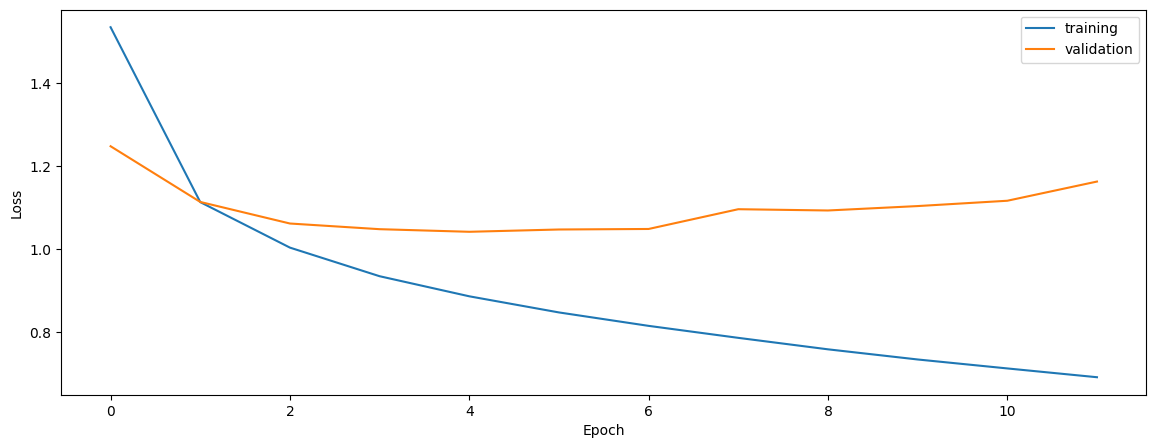

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuarcy, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getAccuarcy(train[1],train_pred))
print(getAccuarcy(val[1],val_pred))
print(getAccuarcy(test[1],test_pred))

train
0.6675762060522492
0.5930447495877988
0.6347550983831116


In [8]:
props2 = props.copy()
props2['balance_data'] = False
props2['include_warp'] = True
gen2 = DataGenerator(**props2)
train2, val2, test2 = gen2.getData()

train_pred2 = predictInBatches(model,train2[0],architecture['batch_size'])
val_pred2 = predictInBatches(model,val2[0],architecture['batch_size'])
test_pred2 = predictInBatches(model,test2[0],architecture['batch_size'])

print('normalized')
print(getAccuarcy(train2[1],train_pred2))
print(getAccuarcy(val2[1],val_pred2))
print(getAccuarcy(test2[1],test_pred2))

normalized
0.6035191246077203
0.5641099083438685
0.5571353450368093


In [9]:
print('native')
print(getAccuarcy(train2[1][train2[2]],train_pred2[train2[2]]))
print(getAccuarcy(val2[1][val2[2]],val_pred2[val2[2]]))
print(getAccuarcy(test2[1][test2[2]],test_pred2[test2[2]]))

native
0.599548333266625
0.5724576844955992
0.5556170632064923


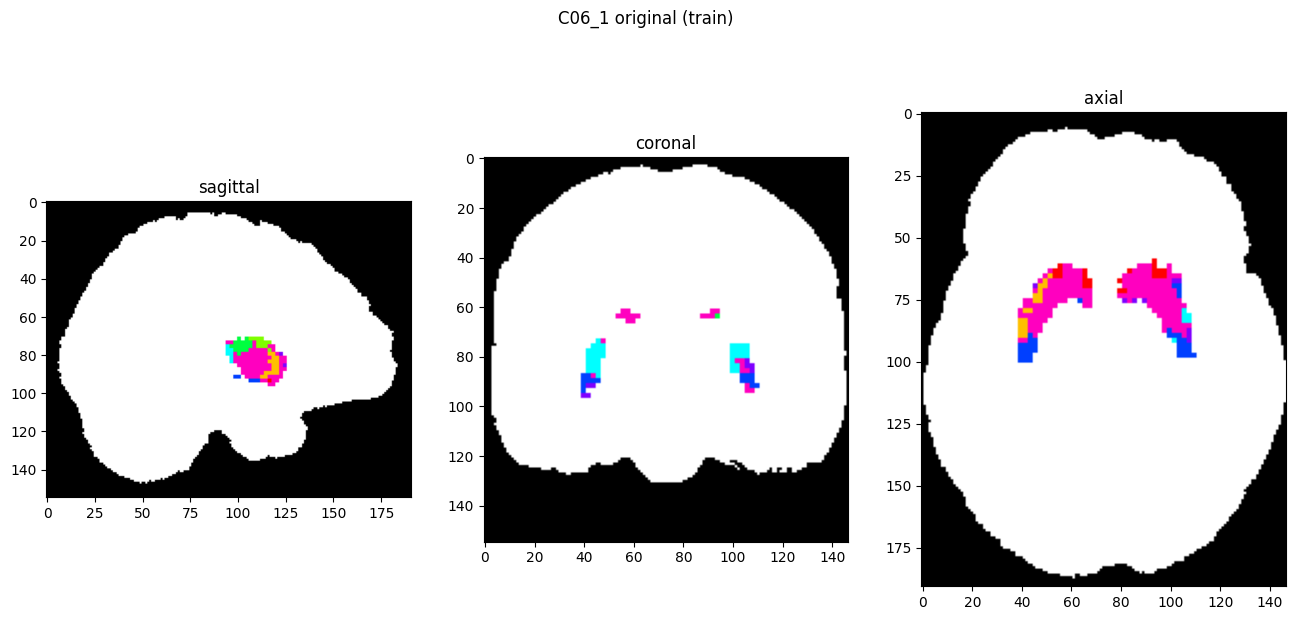

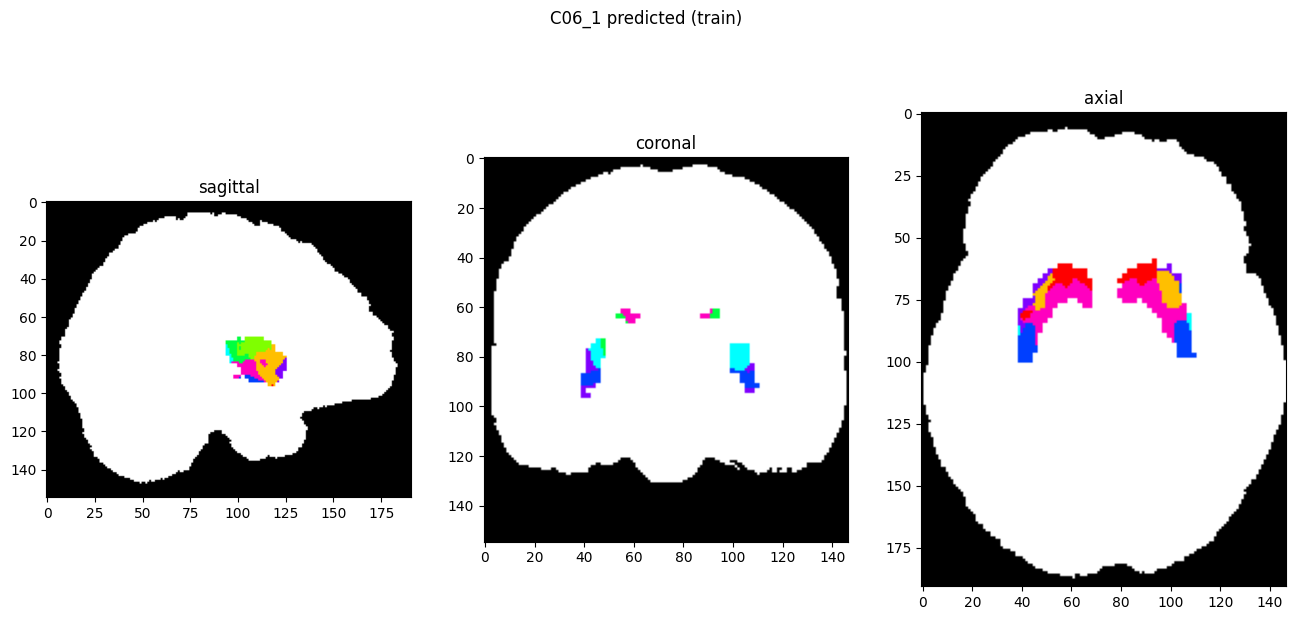

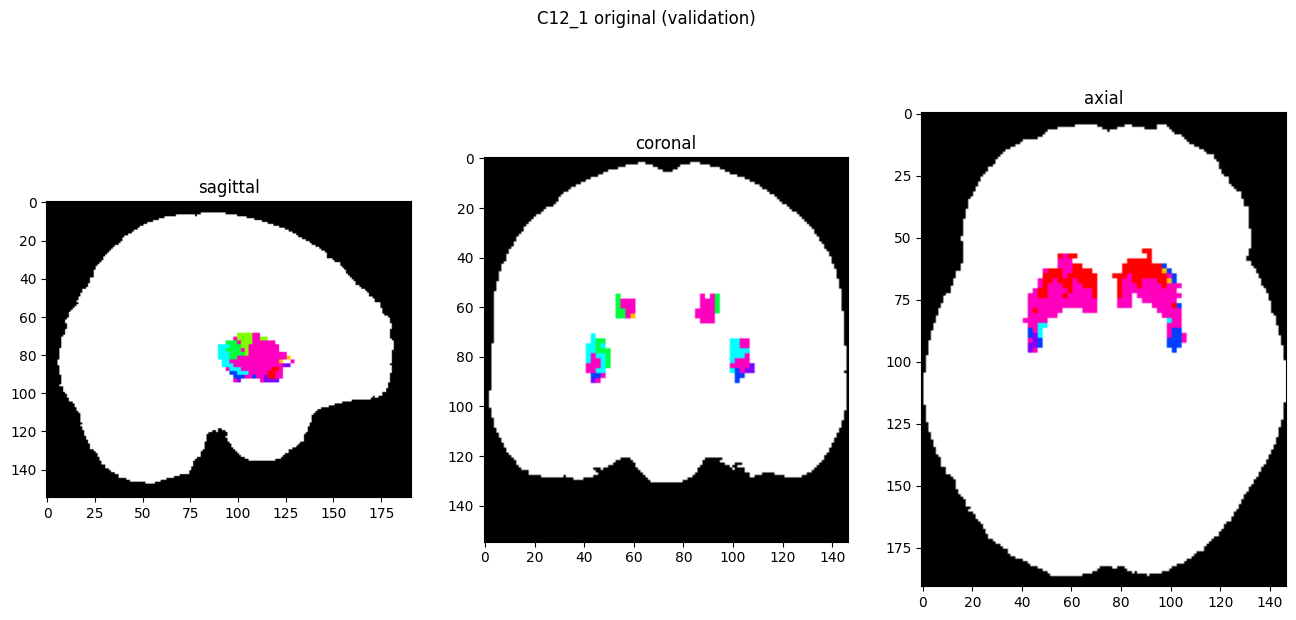

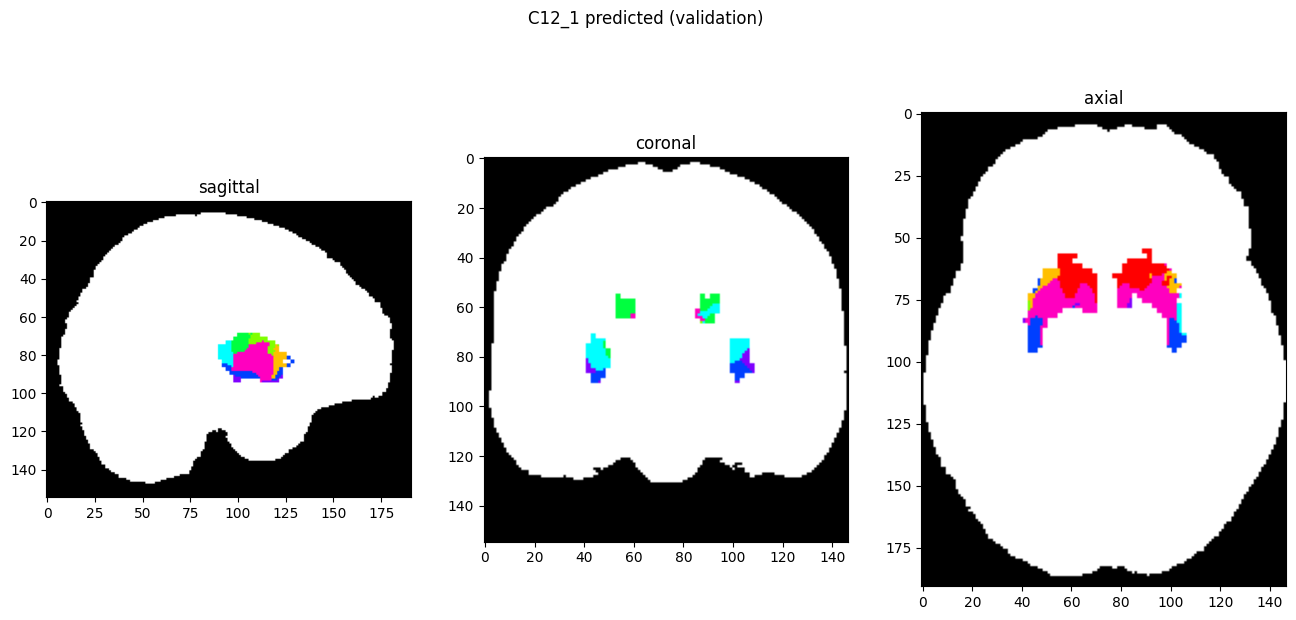

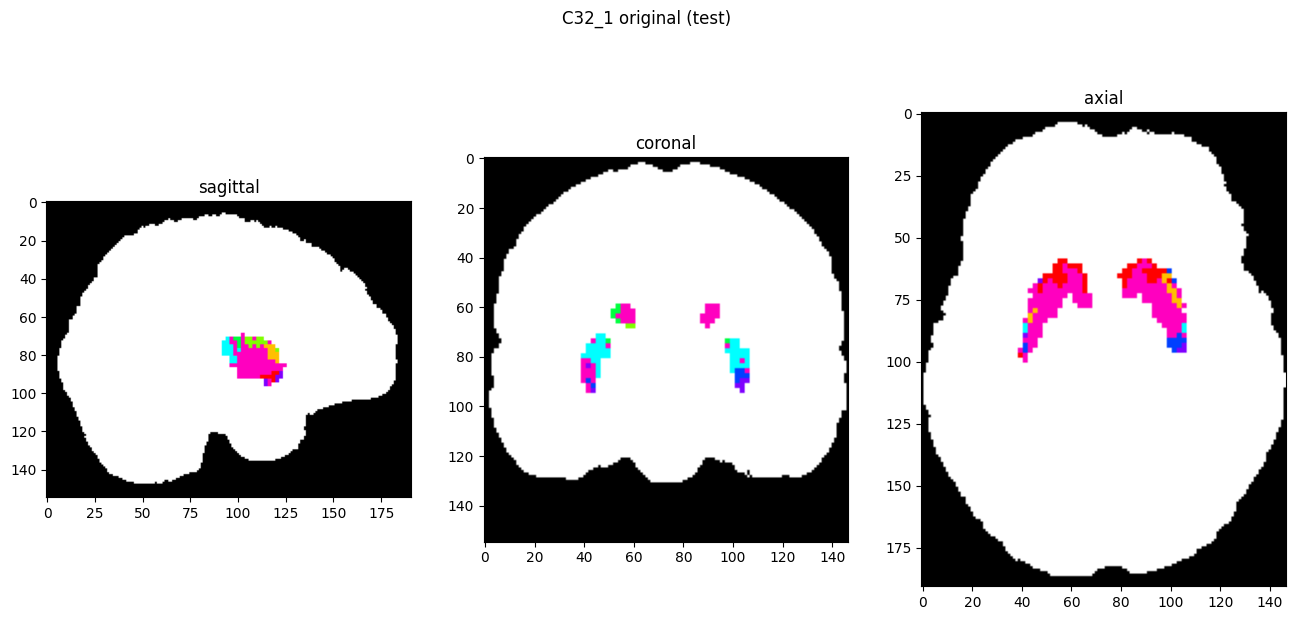

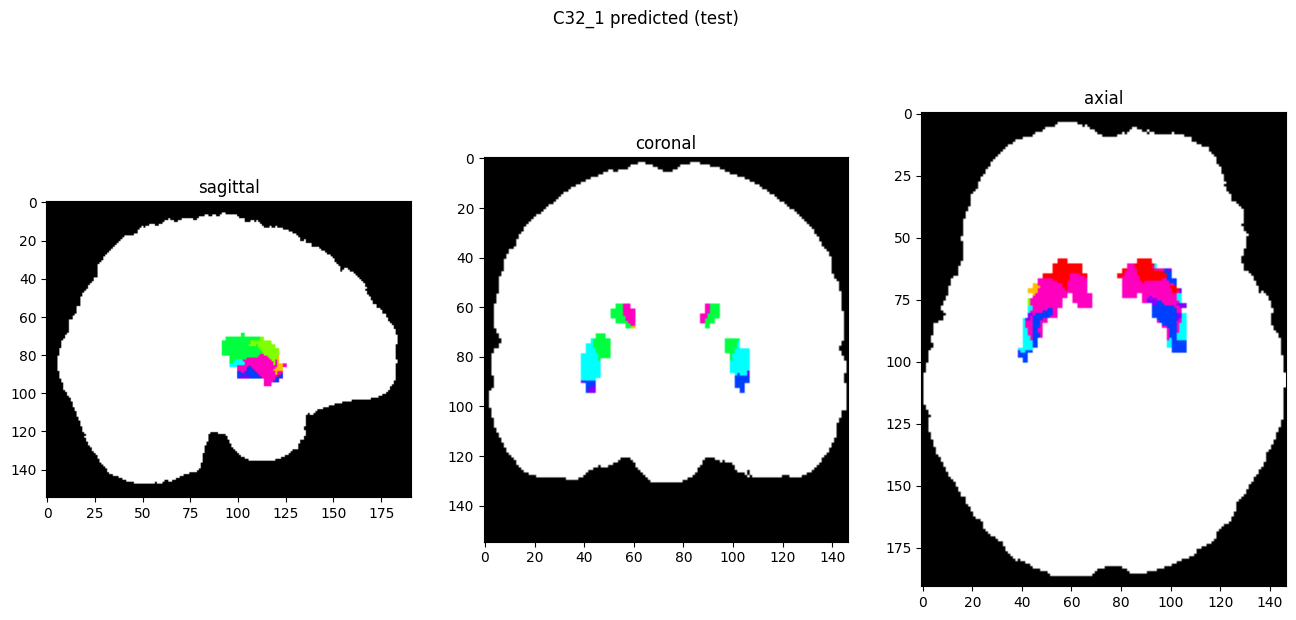

In [10]:
showResults(model, gen, threshold=0)